# **Section 1: Setup and Imports** <a id="1"></a>

In [81]:
# Install if not already installed (uncomment below in Jupyter)
# !pip install openai python-dotenv
# %pip install duckduckgo-search

from openai import OpenAI # for OpenAI API
import os # for environment variables
from dotenv import load_dotenv # for loading environment variables
from difflib import SequenceMatcher # for comparing strings
import re # regular expressions
from duckduckgo_search import DDGS # for searching DuckDuckGo (web information retrieval)
import matplotlib.pyplot as plt # for plotting
import matplotlib.patches as mpatches # for patches
from markdown2 import markdown # for converting markdown to HTML
import asyncio # for async functions
from playwright.async_api import async_playwright # for scraping web pages
import webbrowser # for opening web pages
import difflib # for comparing strings
import textstat # for text statistics
from langchain_community.tools import WikipediaQueryRun # for querying Wikipedia
from langchain_community.utilities import WikipediaAPIWrapper # for querying Wikipedia
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
from textblob import TextBlob # for sentiment analysis
from langchain_community.utilities import SerpAPIWrapper # for querying SERP API
import spacy  # for NLP
nlp = spacy.load("en_core_web_sm")
from langchain.chains import LLMMathChain # for chaining models - math
from langchain_community.tools import ArxivQueryRun # for querying ArXiv
from langchain_community.utilities.arxiv import ArxivAPIWrapper # for querying ArXiv
arxiv_tool = ArxivQueryRun(api_wrapper=ArxivAPIWrapper(load_max_docs=3))
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import docx # for Word documents
import fitz # for PDFs
from pathlib import Path # for file paths


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/liammckendry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load the OpenAI API key from .env file
load_dotenv()

# Create a client instance
my_openai_api_key=os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=my_openai_api_key)

# Check to confirm it's loaded (optional)
print("✅ API key loaded:", my_openai_api_key is not None)

✅ API key loaded: True


In [3]:
load_dotenv()
serpapi_key = os.getenv("SERPAPI_API_KEY")

# Check to confirm it's loaded (optional)
print("✅ API key loaded:", serpapi_key is not None)

serp_tool = SerpAPIWrapper(serpapi_api_key=serpapi_key)

serp_tool.run("examples of NIST framework in healthcare")


✅ API key loaded: True


'[\' entity_type: related_questions.\', \'One of the frameworks recommended by the Task Group to help health care organizations manage cybersecurity and bolster their security posture is ...\', \'The NIST CSF can help healthcare organizations reduce cyber risk, cut costs, and potentially reduce cyber insurance premiums. Even though the ...\', \'Revised draft publication aims to help organizations comply with HIPAA Security Rule.\', \'The NIST Cybersecurity Framework consists of five core functions that guide cybersecurity risk management. These functions—Identify, Protect, ...\', "The NIST CSF 2.0 introduces a nuanced approach to managing cybersecurity risks in healthcare, aligning closely with the sector\'s need for ...", \'For example, one of the most popular health cybersecurity framework called NIST. NIST ensures security using its core elements, implementation ...\', \'The NIST Privacy Framework is designed to bridge the gap between information security and individual privacy.\', 

In [4]:
from langchain.chat_models import ChatOpenAI # for chaining models - chat
llm_math = LLMMathChain.from_llm(ChatOpenAI(temperature=0, model="gpt-3.5-turbo")) # temp = 0 ensures deterministic results (math precision)

/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_70664/1508302931.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm_math = LLMMathChain.from_llm(ChatOpenAI(temperature=0, model="gpt-3.5-turbo")) # temp = 0 ensures deterministic results (math precision)


# **Section 2: Functions** <a id="2"></a>
## **2.1 OpenAI Functions** <a id="2.1"></a>

In [5]:
# Function to call OpenAI's ChatCompletion API with structured messages
def call_openai(messages, model="gpt-3.5-turbo", temperature=0.7):
    """
    Calls OpenAI's ChatCompletion API with structured messages.

    Parameters:
    messages (list): A list of message dictionaries, where each dictionary contains 'role' and 'content' keys.
    model (str): The model to use for the API call. Default is "gpt-3.5-turbo".
    temperature (float): The sampling temperature to use. Higher values mean the model will take more risks. Default is 0.7.

    Workflow:
    1. The function takes the input parameters and calls the OpenAI ChatCompletion API.
    2. The API returns a response containing multiple choices.
    3. The function extracts the content of the first choice from the response.

    Returns:
    str: The content of the first choice from the API response.
    """

    try:
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=temperature
        )
        return response.choices[0].message.content.strip() # Extract the content of the first choice
    except Exception as e:
        return f"⚠️ Tool execution error: {str(e)}"

In [6]:
# Helper to construct system + user messages for the reasoning agent
def build_review_prompt(report_text, history=[]):
    """
    Constructs system and user messages for the reasoning agent to review a consulting report.

    Parameters:
    report_text (str): The text of the consulting report to be reviewed.
    history (list): A list of previous messages (optional). Default is an empty list.

    Workflow:
    1. The function creates a system message that sets the context for the reasoning agent.
    2. It then creates a user message containing the consulting report text.
    3. The function combines the system message, the history of previous messages, and the user message into a single list.

    Returns:
    list: A list of message dictionaries, including the system message, any historical messages, and the user message.
    """
    system_msg = {
        "role": "system",
        "content": (
            "You are an experienced IT strategy consultant. "
            "You are reviewing a consulting report for completeness, clarity, risks, and alignment with best practices. "
            "Think step-by-step and identify gaps, ask clarifying questions, or suggest improvements. "
            "Your goal is to provide helpful, critical feedback using your expert knowledge."
        )
    }

    user_msg = {
        "role": "user",
        "content": f"Here is the consulting report to review:\n\n{report_text}"
    }

    return [system_msg] + history + [user_msg]


In [7]:
# Track total tokens used and estimated cost
total_tokens_used = 0
estimated_cost_usd = 0.0

# Cost per 1K tokens for GPT-3.5-turbo (adjust if using GPT-4)
COST_PER_1K_TOKENS = 0.0015

def call_openai_with_tracking(messages, model="gpt-3.5-turbo", temperature=0.7, max_tokens=500):
    """
    Calls OpenAI's ChatCompletion API with structured messages and tracks token usage and estimated cost.

    Parameters:
    messages (list): A list of message dictionaries, where each dictionary contains 'role' and 'content' keys.
    model (str): The model to use for the API call. Default is "gpt-3.5-turbo".
    temperature (float): The sampling temperature to use. Higher values mean the model will take more risks. Default is 0.7.
    max_tokens (int): The maximum number of tokens to generate in the completion. Default is 500.

    Workflow:
    1. The function takes the input parameters and calls the OpenAI ChatCompletion API.
    2. The API returns a response containing multiple choices and token usage information.
    3. The function extracts the content of the first choice from the response.
    4. It updates the total tokens used and the estimated cost in USD.
    5. It logs the prompt tokens, completion tokens, total tokens used so far, and the estimated cost.

    Returns:
    str: The content of the first choice from the API response.
    """
    global total_tokens_used, estimated_cost_usd

    try:
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens
        )
    except Exception as e:
        return f"⚠️ Tool execution error: {str(e)}"

    # Extract token usage and calculate estimated cost
    usage = response.usage
    prompt_tokens = usage.prompt_tokens or 0
    completion_tokens = usage.completion_tokens or 0
    total = usage.total_tokens or (prompt_tokens + completion_tokens)

    # Update tracking
    total_tokens_used += total
    estimated_cost_usd += (total / 1000) * COST_PER_1K_TOKENS

    # Logging
    print(f"🔢 Prompt: {prompt_tokens} tokens | Completion: {completion_tokens} tokens | Total so far: {total_tokens_used} tokens")
    print(f"💰 Estimated cost so far: ${estimated_cost_usd:.4f} USD")

    return response.choices[0].message.content.strip()

## **2.2 Data Preprocessing Functions** <a id="2.2"></a>

In [8]:
def load_report_text_from_file(filepath):
    """
    Loads text from a supported file format (txt, md, docx, pdf).
    """
    ext = Path(filepath).suffix.lower()

    if ext in [".txt", ".md"]:
        with open(filepath, "r", encoding="utf-8") as f:
            return f.read()
    elif ext == ".docx":
        doc = docx.Document(filepath)
        return "\n".join([p.text for p in doc.paragraphs])
    elif ext == ".pdf":
        import fitz  # PyMuPDF
        doc = fitz.open(filepath)
        return "\n".join([page.get_text() for page in doc])
    else:
        raise ValueError("Unsupported file format. Use .txt, .md, .docx, or .pdf")


In [85]:
def split_report_into_sections(report_text):
    """
    Splits a report into sections based on headers.

    Purpose:
    This function processes a report text and splits it into sections using headers as delimiters. 
    It identifies headers based on lines ending with a colon (":") and assumes that headers contain 
    up to four words. Content before the first header is treated as the "Introduction" section.

    Parameters:
    report_text (str): The full text of the report to be split into sections.

    Workflow:
    1. Initializes an empty dictionary `sections` to store the output as {section_name: text}.
    2. Splits the report into lines and iterates through each line.
    3. Skips blank lines.
    4. Detects section headers based on lines ending with a colon and containing up to four words.
       - If a header is detected:
         a. Saves the content of the previous section (if any) into the `sections` dictionary.
         b. Updates the `current_section` to the new header.
         c. Clears the buffer for the new section's content.
       - If no header is detected, appends the line to the buffer for the current section.
    5. After processing all lines, saves the content of the last section or treats it as "Introduction" 
       if no headers were found.
    6. Returns the `sections` dictionary containing section names as keys and their corresponding content as values.

    Returns:
    dict: A dictionary where keys are section names and values are the corresponding section content.
    """
    sections = {}       # To store final output as {section_name: text}
    lines = report_text.strip().split("\n")  # Break the report into lines
    current_section = None  # Track the active section label
    buffer = []        # Temporarily hold lines belonging to the current section

    for line in lines:
        line = line.strip()
        if not line:
            continue  # skip blank lines

        # Detect section header
        if line.endswith(":") and len(line.split()) <= 4:
            # Store previous buffer if it exists
            if current_section is None and buffer:  # Handle content before the first header
                sections["Introduction"] = "\n".join(buffer).strip()
            elif current_section:  # Save the previous section's content
                sections[current_section] = "\n".join(buffer).strip()

            current_section = line.replace(":", "").strip()  # Update the current_section label
            buffer = []  # Clear the buffer for new section content
        else:
            buffer.append(line)  # Add line to buffer for the current section

    # Save last section or intro
    if current_section:  # Save the last section's content
        sections[current_section] = "\n".join(buffer).strip()
    elif buffer:  # Handle content with no headers
        sections["Introduction"] = "\n".join(buffer).strip()

    # After section splitting
    normalized_sections = {}
    for label, text in sections.items():
        canonical = map_section_to_canonical(label)
        normalized_sections[canonical or label] = text  # use original if no match

    return normalized_sections


In [ ]:
# Define the canonical section map for mapping section names to canonical names (similar to the tool catalog)
canonical_section_map = {
    "Introduction": ["header", "intro", "project context", "introduction", "overview"],
    "Summary": ["summary", "executive summary"],
    "Goals & Objectives": ["goals", "objectives", "strategic priorities"],
    "Current State Assessment": ["current state", "as-is", "status quo"],
    "Future State": ["future state", "to-be", "vision", "target state"],
    "Key Recommendations": ["recommendations", "our recommendations", "next steps"],
    "Implementation Plan": ["implementation plan", "roadmap", "deployment", "schedule", "timeline", "phasing"],
    "Benefits": ["benefits", "value", "expected outcomes"],
    "Costs": ["costs", "financials", "budget", "investment"],
    "Resources": ["resources", "team structure", "staffing", "governance"],
    "Risks & Mitigations": ["risks", "mitigations", "risk mitigation"]
}


In [86]:
def map_section_to_canonical(label, threshold=0.6, use_llm_fallback=True):
    """
    Maps a section label to its canonical name.

    Purpose:
    This function attempts to map a given section label to a canonical section name using a combination of direct matching, fuzzy matching, and optionally a language model fallback. It is useful for normalizing section names in a report to a standard set of canonical names.

    Parameters:
    label (str): The section label to map to a canonical name.
    threshold (float): The similarity threshold for fuzzy matching. Default is 0.6.
    use_llm_fallback (bool): Whether to use a language model fallback if no match is found. Default is True.

    Workflow:
    1. Cleans the input label by stripping whitespace and converting it to lowercase.
    2. Performs direct matching:
       - Checks if the label matches any canonical name or its variants directly or as a substring.
    3. Performs fuzzy matching:
       - Uses fuzzy string matching to find the closest match among all canonical names and their variants.
       - If a match is found with a similarity ratio above the threshold, returns the corresponding canonical name.
    4. Uses a language model fallback (optional):
       - If no match is found through direct or fuzzy matching, calls the `guess_canonical_section_with_llm` function to infer the canonical name using a language model.
    5. Returns `None` if no match is found through any method.

    Returns:
    str or None: The canonical section name if a match is found, or `None` if no match is found.
    """
    label_clean = label.strip().lower()

    # 1. Direct and substring match
    for canonical, variants in canonical_section_map.items():
        for variant in variants:
            if variant in label_clean:
                return canonical
        if canonical.lower() in label_clean:
            return canonical

    # 2. Fuzzy match
    all_variants = {v.lower(): canon for canon, variants in canonical_section_map.items() for v in variants}
    match = difflib.get_close_matches(label_clean, all_variants.keys(), n=1, cutoff=threshold)
    if match:
        return all_variants[match[0]]

    # 3. LLM fallback
    if use_llm_fallback:
        return guess_canonical_section_with_llm(label)

    return None


In [ ]:
def guess_canonical_section_with_llm(label, model="gpt-3.5-turbo", temperature=0.2):
    """
    Uses LLM to guess the canonical section name from a list of known options.

    Returns:
    str or None
    """
    canonical_names = list(canonical_section_map.keys())
    prompt = (
        "You're an expert in business consulting. "
        "Given this section title: '{label}', what is the most likely standard section label "
        "from the following options:\n\n"
        + ", ".join(canonical_names) +
        "\n\nReturn only the best matching label. If unsure, return 'Unknown'."
    ).replace("{label}", label.strip())

    messages = [{"role": "user", "content": prompt}]
    result = call_openai_with_tracking(messages, model=model, temperature=temperature)

    cleaned = result.strip()
    if cleaned in canonical_names:
        return cleaned
    elif "unknown" in cleaned.lower():
        return None
    else:
        # Try fuzzy match if response is slightly off (e.g., "Implementation Timeline")
        return difflib.get_close_matches(cleaned, canonical_names, n=1, cutoff=0.6)[0] if difflib.get_close_matches(cleaned, canonical_names) else None
    

## **2.3 Static Reasoning Agent Functions** <a id="2.3"></a>

In [10]:
class ITReportReviewer:
    """
    A class to review sections of an IT consulting report using OpenAI's ChatCompletion API.

    Process:
    1. Initializes the reviewer with the report sections
    2. Lets it review one section at a time using real reasoning
    3. Stores and prints each review with feedback

    Attributes:
    sections (dict): A dictionary where keys are section headers and values are the corresponding section contents.
    model (str): The model to use for the API call. Default is "gpt-3.5-turbo".
    temperature (float): The sampling temperature to use. Higher values mean the model will take more risks. Default is 0.7.
    review_history (list): A list to store the history of reviews for each section.

    Methods:
    review_section(section_name):
        Reviews a specific section of the report using OpenAI's ChatCompletion API.
    """
    
    def __init__(self, report_sections, model="gpt-3.5-turbo", temperature=0.7):
        """
        Initializes the ITReportReviewer with the given report sections, model, and temperature.

        Parameters:
        report_sections (dict): A dictionary where keys are section headers and values are the corresponding section contents.
        model (str): The model to use for the API call. Default is "gpt-3.5-turbo".
        temperature (float): The sampling temperature to use. Higher values mean the model will take more risks. Default is 0.7.
        """
        self.sections = report_sections
        self.model = model
        self.temperature = temperature
        self.review_history = []

    def review_section(self, section_name):
        """
        Reviews a specific section of the report using OpenAI's ChatCompletion API.

        Parameters:
        section_name (str): The name of the section to review.

        Workflow:
        1. Retrieves the text of the specified section from the sections dictionary.
        2. If the section is empty or missing, prints a warning message.
        3. Builds a prompt for reviewing the section using the build_review_prompt function.
        4. Calls the OpenAI ChatCompletion API with tracking using the call_openai_with_tracking function.
        5. Saves the review in the review_history attribute.
        6. Prints the review for the specified section.

        Returns:
        None
        """
        section_text = self.sections.get(section_name, "")
        if not section_text:
            print(f"⚠️ Section '{section_name}' is empty or missing.")
            return

        # Build prompt for reviewing the section
        messages = build_review_prompt(
            report_text=f"Section: {section_name}\n\n{section_text}",
            history=[]
        )

        # Get AI-generated reasoning using tracked OpenAI call
        review = call_openai_with_tracking(messages, model=self.model, temperature=self.temperature)

        # Save the review
        self.review_history.append({
            "section": section_name,
            "review": review
        })

        print(f"\n✅ Review for section '{section_name}':\n{review}\n{'-'*60}")


In [11]:
def summarize_full_review(agent):
    # Combine all reviews into a single prompt
    combined_review_text = ""
    for step in agent.review_history:
        combined_review_text += f"Section: {step['section']}\nFeedback: {step['review']}\n\n"

    # Build new prompt asking for a final report assessment
    messages = [
        {
            "role": "system",
            "content": (
                "You are an expert IT strategy consultant reviewing an internal report assessment. "
                "Summarize the overall quality of the report based on the following section reviews. "
                "Highlight gaps, strengths, and suggest next steps to improve the report."
            )
        },
        {
            "role": "user",
            "content": combined_review_text
        }
    ]

    summary = call_openai_with_tracking(messages)
    return summary

## **2.4 ReAct Reasoning Agent Functions** <a id="2.4"></a>

In [12]:
class ReActConsultantAgent:
    """
    A class to review sections of an IT consulting report using the ReAct (Reason + Act) framework with OpenAI's ChatCompletion API.

    Process:
    1. Initializes the agent with the section name and text.
    2. Builds a prompt for the ReAct framework.
    3. Tracks the history of thoughts, actions, and observations.

    Attributes:
    section_name (str): The name of the section to review.
    section_text (str): The text of the section to review.
    model (str): The model to use for the API call. Default is "gpt-3.5-turbo".
    temperature (float): The sampling temperature to use. Higher values mean the model will take more risks. Default is 0.7.
    history (list): A list to store the history of thoughts, actions, and observations.

    Methods:
    build_react_prompt():
        Builds a prompt for the ReAct framework based on the section text and history.
    """

    def __init__(self, section_name, section_text, model="gpt-3.5-turbo", temperature=0.7):
        """
        Initializes the ReActConsultantAgent with the given section name, section text, model, and temperature.

        Parameters:
        section_name (str): The name of the section to review.
        section_text (str): The text of the section to review.
        model (str): The model to use for the API call. Default is "gpt-3.5-turbo".
        temperature (float): The sampling temperature to use. Higher values mean the model will take more risks. Default is 0.7.
        """
        self.section_name = section_name
        self.section_text = section_text
        self.model = model
        self.temperature = temperature
        self.history = []
        self.tool_usage = {}  # {action_name: count}
        self.memory = {
            "section_notes": {},     # {section_name: [insight1, insight2, ...]}
            "cross_section_flags": [],  # [(sectionA, sectionB, observation)]
            "tool_history": []       # [(step_number, action, section)]
        }

    def build_react_prompt(self):
        """
        Builds a prompt for the ReAct framework based on the section text and history.

        Workflow:
        1. Constructs a base prompt with the section name and text.
        2. Iterates through the history of thoughts, actions, and observations, appending them to the base prompt.
        3. Adds a final line asking for the next thought and action.

        Returns:
        list: A list containing a single dictionary with the role 'user' and the constructed prompt as content.
        """
        base_prompt = (
            f"You are an expert IT strategy consultant reviewing a report section titled '{self.section_name}'.\n"
            "You are using ReAct (Reason + Act) to think through the review.\n\n"
            "Format each response like this:\n"
            "Thought: <your reasoning>\n"
            "Action: <one of: ask_question, flag_risk, recommend_fix, summarize>\n\n"
            f"Here is the section content:\n{self.section_text}\n\n"
        )

        for step in self.history:
            base_prompt += f"Thought: {step['thought']}\n"
            base_prompt += f"Action: {step['action']}\n"
            base_prompt += f"Observation: {step['observation']}\n\n"

        base_prompt += "What is your next Thought and Action?"

        return [{"role": "user", "content": base_prompt}]

    def build_react_prompt_withTools(self):
            """
            Builds a prompt for the ReAct framework based on the section text and history.

            Workflow:
            1. Constructs a base prompt with the section name and text.
            2. Iterates through the history of thoughts, actions, and observations, appending them to the base prompt.
            3. Adds a final line asking for the next thought and action.
            For the check_guideline action, the prompt includes a placeholder for the topic.
            LLM infers topic from the section_text

            Returns:
            list: A list containing a single dictionary with the role 'user' and the constructed prompt as content.
            """
            tool_hint_text, tools_to_focus = build_tool_hints(self)

            base_prompt = (
                f"You are an expert IT strategy consultant reviewing a report section titled '{self.section_name}'.\n"
                "You are using ReAct (Reason + Act) to think through the review.\n\n"
                "Format each response like this:\n"
                "Thought: <your reasoning>\n"
                "Action: <choose ONE tool from the prioritized list below, unless you strongly believe another tool is better>\n\n"
                f"Prioritized tools for this section:\n{tool_hint_text}\n\n"
                "Available tools and their descriptions:\n"
            )

            base_prompt += format_tool_catalog_for_prompt(tool_catalog)
            base_prompt += f"Here is the section content:\n{self.section_text}\n\n"
            
            for step in self.history:
                base_prompt += f"Thought: {step['thought']}\n"
                base_prompt += f"Action: {step['action']}\n"
                base_prompt += f"Observation: {step['observation']}\n\n"

            base_prompt += "What is your next Thought and Action?"

            return [{"role": "user", "content": base_prompt}]


In [13]:
def run_react_loop_static(agent, max_steps=5):
    """
    Runs the ReAct (Reason + Act) loop for a specified number of steps.

    Purpose:
    This function iterates through a reasoning and action loop using the ReAct framework to review a section of an IT consulting report. It generates thoughts, actions, and observations at each step, and stores the history of these steps.

    Parameters:
    agent (ReActConsultantAgent): An instance of the ReActConsultantAgent class, initialized with the section name and text.
    max_steps (int): The maximum number of steps to run the loop. Default is 5.

    Workflow:
    1. Iterates through the loop for a maximum of `max_steps` times.
    2. In each iteration:
    - Calls `agent.build_react_prompt()` to construct the prompt for the ReAct framework.
    - Calls `call_openai_with_tracking()` to get the response from the OpenAI API.
    - Parses the response to extract the thought and action.
    - Generates an observation based on the action.
    - Stores the thought, action, and observation in the agent's history.
    - Prints the result of the current step.
    - Breaks the loop if the action is "summarize".
    3. Returns the full reasoning history.

    Returns:
    list: A list of dictionaries, where each dictionary contains the thought, action, and observation for each step.
    """
    for step_num in range(max_steps):
        messages = agent.build_react_prompt()
        response = call_openai_with_tracking(messages, model=agent.model, temperature=agent.temperature)

        # Parse response
        try:
            lines = response.strip().split("\n")
            thought = next(line.split(":", 1)[1].strip() for line in lines if line.lower().startswith("thought"))
            action = next(line.split(":", 1)[1].strip() for line in lines if line.lower().startswith("action"))
        except:
            print("⚠️ Failed to parse model response.")
            break

        # Generate observation based on action
        if action == "ask_question":
            observation = "Good question to ask the client for clarification."
        elif action == "flag_risk":
            observation = "This is a legitimate risk that should be addressed."
        elif action == "recommend_fix":
            observation = "The recommendation improves the section's clarity and compliance."
        elif action == "summarize":
            observation = "Review complete."
        else:
            observation = "Unrecognized action."

        # Store step
        agent.history.append({
            "thought": thought,
            "action": action,
            "observation": observation
        })

        # Print result of this step
        print(f"\n🔁 Step {step_num + 1}")
        print(f"🧠 Thought: {thought}")
        print(f"⚙️ Action: {action}")
        print(f"👀 Observation: {observation}")

        if action == "summarize":
            break

    # Return full reasoning history
    return agent.history


In [14]:
def run_react_loop_check_withTool(agent, max_steps=5):
    """
    Runs the ReAct (Reason + Act) loop for a specified number of steps.

    Purpose:
    This function iterates through a reasoning and action loop using the ReAct framework to review a section of an IT consulting report. It generates thoughts, actions, and observations at each step, and stores the history of these steps.

    Parameters:
    agent (ReActConsultantAgent): An instance of the ReActConsultantAgent class, initialized with the section name and text.
    max_steps (int): The maximum number of steps to run the loop. Default is 5.

    Workflow:
    1. Iterates through the loop for a maximum of `max_steps` times.
    2. In each iteration:
       - Calls `agent.build_react_prompt()` to construct the prompt for the ReAct framework.
       - Calls `call_openai_with_tracking()` to get the response from the OpenAI API.
       - Parses the response to extract the thought and action.
       - Generates an observation based on the action.
       - Stores the thought, action, and observation in the agent's history.
       - Prints the result of the current step.
       - Breaks the loop if the action is "summarize".
    3. Returns the full reasoning history.

    Returns:
    list: A list of dictionaries, where each dictionary contains the thought, action, and observation for each step.
    """
    for step_num in range(max_steps):
        messages = agent.build_react_prompt_withTools()
        response = call_openai_with_tracking(messages, model=agent.model, temperature=agent.temperature)

        # Parse response
        try:
            lines = response.strip().split("\n")
            thought = next(line.split(":", 1)[1].strip() for line in lines if line.lower().startswith("thought"))
            action = next(line.split(":", 1)[1].strip() for line in lines if line.lower().startswith("action"))
            # Log tool usage
            if hasattr(agent, "tool_usage"):
                agent.tool_usage[action] = agent.tool_usage.get(action, 0) + 1
        except:
            print("⚠️ Failed to parse model response.")
            break

        # Generate observation based on action
        observation = dispatch_tool_action(agent, action)

        # Track tool history
        agent.memory["tool_history"].append((step_num, action, agent.section_name))

        # Special case for section comparisons
        if action.startswith("compare_with_other_section"):
            match = re.match(r'compare_with_other_section\["(.+?)",\s*"(.+?)"\]', action)
            if match:
                sectionA, sectionB = match.groups()
                agent.memory["cross_section_flags"].append((sectionA, sectionB, observation))

        # Store step
        agent.history.append({
            "thought": thought,
            "action": action,
            "observation": observation
        })
        
        # Print result of this step
        print(f"\n🔁 Step {step_num + 1}")
        print(f"🧠 Thought: {thought}")
        print(f"⚙️ Action: {action}")
        print(f"👀 Observation: {observation}")

        if action == "summarize":
            break
    
    # Summarize and store section notes, scores, fixes, confidence level, raw ouputs
    summarize_and_score_section(agent)

    # Return full reasoning history
    return agent.history


In [15]:
def dispatch_tool_action(agent, action):
    print(f"🛠️ Tool action: {action}")
    try:
        if action.startswith("check_guideline"):
            match = re.match(r'check_guideline\["(.+?)"\]', action)
            if match:
                return check_guideline(match.group(1))
        elif action.startswith("keyword_match_in_section"):
            match = re.match(r'keyword_match_in_section\["(.+?)"\]', action)
            if match:
                return keyword_match_in_section(match.group(1), agent.section_text)
        elif action.startswith("check_timeline_feasibility"):
            match = re.match(r'check_timeline_feasibility\["(.+?)"\]', action)
            if match:
                return check_timeline_feasibility(match.group(1))
        elif action.startswith("search_report"):
            match = re.match(r'search_report\["(.+?)"\]', action)
            if match:
                return search_report(match.group(1), report_sections)
        elif action.startswith("search_web"):
            match = re.match(r'search_web\["(.+?)"\]', action)
            if match:
                return search_web(match.group(1))
        elif action == "check_for_jargon":
            return check_for_jargon(agent.section_text)
        elif action == "generate_client_questions":
            return generate_client_questions(agent.section_text)
        elif action == "highlight_missing_sections":
            return highlight_missing_sections(report_sections)
        elif action.startswith("check_alignment_with_goals"):
            match = re.match(r'check_alignment_with_goals\["(.+?)"\]', action)
            if match:
                return check_alignment_with_goals(match.group(1), report_sections)
        elif action.startswith("compare_with_other_section"):
            match = re.match(r'compare_with_other_section\["(.+?)",\s*"(.+?)"\]', action)
            if match:
                return compare_with_other_section(match.group(1), match.group(2), report_sections)
        elif action.startswith("check_summary_support"):
            match = re.match(r'check_summary_support\["(.+?)"\]', action)
            if match:
                return check_summary_support(match.group(1), report_sections)
        elif action == "evaluate_smart_goals":
            return evaluate_smart_goals(agent.section_text)
        elif action.startswith("check_recommendation_alignment"):
            match = re.match(r'check_recommendation_alignment\["(.+?)"\]', action)
            if match:
                goals = report_sections.get("Goals & Objectives", "")
                return check_recommendation_alignment(match.group(1), goals)
        elif action == "ask_question":
            return "Good question to ask the client for clarification."
        elif action == "flag_risk":
            return "This is a legitimate risk that should be addressed."
        elif action == "recommend_fix":
            return "The recommendation improves the section's clarity and compliance."
        elif action == "summarize":
            return "Review complete."
        elif action == "tool_help":
            return format_tool_catalog_for_prompt(tool_catalog)
        elif action.startswith("suggest_tool_for"):
            match = re.match(r'suggest_tool_for\["(.+?)"\]', action)
            if match:
                matches = pick_tool_by_intent_fuzzy(match.group(1), tool_catalog)
                if matches:
                    return "Best match based on your goal:\n" + "\n".join([f"{tool} (match: {score})" for tool, score in matches])
                else:
                    return "⚠️ No matching tool found. Showing available tools:\n" + format_tool_catalog_for_prompt(tool_catalog)
        elif action == "final_summary":
            return generate_final_summary(agent)
        elif action == "check_readability": 
            return check_readability(agent.section_text)
        elif action.startswith("search_wikipedia"):
            match = re.match(r'search_wikipedia\["(.+?)"\]', action)
            if match:
                query = match.group(1)
                return wikipedia.run(query)
            else:
                return "⚠️ Could not parse search_wikipedia action."
        elif action == "analyze_tone_textblob":
            return analyze_tone_textblob(agent.section_text)
        elif action.startswith("search_serpapi"):
            match = re.match(r'search_serpapi\["(.+?)"\]', action)
            if match:
                query = match.group(1)
                return search_serpapi(query)
            else:
                return "⚠️ Could not parse search_serpapi action."
        elif action == "extract_named_entities":
            return extract_named_entities(agent.section_text)
        elif action.startswith("analyze_math_question"):
            match = re.match(r'analyze_math_question\["(.+?)"\]', action)
            if match:
                expr = match.group(1)
                return analyze_math_question(expr)
            else:
                return "⚠️ Could not parse analyze_math_question action."
        elif action.startswith("search_arxiv"):
            match = re.match(r'search_arxiv\["(.+?)"\]', action)
            if match:
                query = match.group(1)
                return search_arxiv(query)
            else:
                return "⚠️ Could not parse search_arxiv action."
        elif action == "auto_check_for_academic_support":
            needs_citation, reason = should_search_arxiv(agent.section_text)
            if needs_citation:
                # Automatically create and run an arxiv search
                followup_action = f'search_arxiv["{agent.section_name}"]'
                followup_obs = dispatch_tool_action(agent, followup_action)
                # Log follow-up to memory
                agent.memory.setdefault("academic_support", {})[agent.section_name] = {
                    "reason": reason,
                    "action": followup_action,
                    "observation": followup_obs
                }
                return f"✅ Academic support was added.\nReason: {reason}\n\n{followup_obs}"
            else:
                return f"🟢 No academic support needed.\nReason: {reason}"
        elif action.startswith("should_cite"):
            match = re.match(r'should_cite\["(.+?)"\]', action)
            if match:
                statement = match.group(1)
                needs, reason = should_cite(statement)
                if needs:
                    # Run research-based rewrite
                    improved = auto_fill_gaps_with_research(statement)
                    observation = (
                        f"✅ Citation recommended. Reason: {reason}\n\n"
                        f"📚 Improved statement with research:\n{improved}"
                    )
                    agent.memory.setdefault("enhanced_statements", {})[statement] = improved
                    return observation
                else:
                    observation = f"🟢 No citation needed. Reason: {reason}"
                    return observation
            else:
                return "⚠️ Could not parse should_cite action."
        elif action == "auto_fill_gaps_with_research":
            return auto_fill_gaps_with_research(agent.section_text)
        elif action == "upgrade_section_with_research":
            improved, log, footnotes = upgrade_section_with_research(agent.section_text)
            observation = "🧠 Section upgraded with research. Rewrites:\n"
            for change in log:
                observation += f"- 🔹 '{change['original']}'\n  🧠 → {change['improved']}\n  📚 Reason: {change['reason']}\n\n"

            # Store in memory for final report
            agent.memory.setdefault("section_upgrades", {})[agent.section_name] = {
                "original": agent.section_text,
                "improved": improved,
                "log": log,
                "footnotes": footnotes
            }

            return observation
        else:
            return "Unrecognized action."
    except Exception as e:
        return f"⚠️ Tool execution error: {str(e)}"
    

In [16]:
def summarize_and_score_section(agent):
    section_name = agent.section_name
    section_text = agent.section_text
    goals_text = report_sections.get("Goals & Objectives", None)

    # Summarize
    agent.memory["section_notes"][section_name] = [summarize_section_insights(agent)]

    # Score
    agent.memory.setdefault("section_scores", {})[section_name] = score_section(section_name, section_text, goals_text)

    # Confidence
    agent.memory.setdefault("confidence_levels", {})[section_name] = get_confidence_level(agent)

    # Fix suggestions
    agent.memory.setdefault("section_fixes", {})[section_name] = recommend_fixes(agent)

    # Debug notes
    agent.memory.setdefault("debug_notes", {})[section_name] = agent.history


In [17]:
# Define dicionary of tools available for ReActConsultantAgent to call

tool_catalog = {
    "check_guideline": {
        "description": "Look up a best practice for a given topic",
        "usage": 'check_guideline["cloud security"]',
        "version": "v1.0",
        "examples": [
            "check_guideline[\"data governance\"]",
            "check_guideline[\"migration strategy\"]"
        ]
    },
    "keyword_match_in_section": {
        "description": "Check if a keyword appears in the current section",
        "usage": 'keyword_match_in_section["encryption"]',
        "version": "v1.0",
        "examples": [
            "keyword_match_in_section[\"stakeholders\"]"
        ]
    },
    "check_timeline_feasibility": {
        "description": "Check if a project timeline is realistic for migration",
        "usage": 'check_timeline_feasibility["12 weeks"]',
        "version": "v1.0",
        "examples": [
            "check_timeline_feasibility[\"3 months\"]"
        ]
    },
    "search_report": {
        "description": "Search the entire report for a concept or term",
        "usage": 'search_report["data governance"]',
        "version": "v1.0",
        "examples": [
            "search_report[\"Zero Trust\"]"
        ]
    },
    "ask_question": {
        "description": "Ask a clarifying question about the report",
        "usage": "ask_question",
        "version": "v1.0",
        "examples": ["ask_question"]
    },
    "flag_risk": {
        "description": "Flag a gap, issue, or concern in the section",
        "usage": "flag_risk",
        "version": "v1.0",
        "examples": ["flag_risk"]
    },
    "recommend_fix": {
        "description": "Suggest a specific improvement",
        "usage": "recommend_fix",
        "version": "v1.0",
        "examples": ["recommend_fix"]
    },
    "summarize": {
        "description": "Summarize your review and end the loop",
        "usage": "summarize",
        "version": "v1.0",
        "examples": ["summarize"]
    },
    "tool_help": {
        "description": "View descriptions, usage, and examples for available tools",
        "usage": "tool_help",
        "version": "v1.0",
        "examples": ["tool_help"]
    },
    "suggest_tool_for": {
        "description": "Ask which tool best supports a particular goal or intent",
        "usage": 'suggest_tool_for["goal or intent"]',
        "version": "v1.0",
        "examples": [
            'suggest_tool_for["check if encryption is included"]',
            'suggest_tool_for["evaluate feasibility of 12-week timeline"]'
        ]
    }, 
    "search_web": {
        "description": "Look up a concept, framework, or term on the web (DuckDuckGo)",
        "usage": 'search_web["Zero Trust model"]',
        "version": "v1.0",
        "examples": ['search_web["data mesh"]']
    },
    "check_for_jargon": {
        "description": "Identify jargon or overly technical terms that may need simplification",
        "usage": "check_for_jargon",
        "version": "v1.0",
        "examples": ["check_for_jargon"]
    },
    "generate_client_questions": {
        "description": "Generate clarifying or skeptical questions a client might ask about the section",
        "usage": "generate_client_questions",
        "version": "v1.0",
        "examples": ["generate_client_questions"]
    },
    "highlight_missing_sections": {
        "description": "Identify which expected sections are missing from the report",
        "usage": "highlight_missing_sections",
        "version": "v1.0",
        "examples": ["highlight_missing_sections"]
    },
    "check_alignment_with_goals": {
        "description": "Evaluate how well a report section aligns with the stated goals",
        "usage": 'check_alignment_with_goals["section_name"]',
        "version": "v1.0",
        "examples": ['check_alignment_with_goals["Key Recommendations"]']
    },
    "compare_with_other_section": {
        "description": "Compare two sections to identify overlaps, contradictions, or gaps",
        "usage": 'compare_with_other_section["sectionA", "sectionB"]',
        "version": "v1.0",
        "examples": [
            'compare_with_other_section["Key Recommendations", "Roadmap & Timeline"]',
            'compare_with_other_section["Future State Vision", "Technology Architecture"]'
        ]
    },
    "final_summary": {
        "description": "Generate a final client-facing summary based on insights gathered across all sections",
        "usage": "final_summary",
        "version": "v1.0",
        "examples": ["final_summary"]
    },
    "check_summary_support": {
        "description": "Check if a summary is supported by details in the rest of the report",
        "usage": 'check_summary_support["summary text"]',
        "version": "v1.0",
        "examples": ['check_summary_support["The report outlines benefits of cloud migration..."]']
    },
    "evaluate_smart_goals": {
        "description": "Evaluate whether stated goals follow the SMART criteria (Specific, Measurable, Achievable, Relevant, Time-bound)",
        "usage": "evaluate_smart_goals",
        "version": "v1.0",
        "examples": ["evaluate_smart_goals"]
    },
    "check_recommendation_alignment": {
        "description": "Check whether the recommendations align with the goals of the report",
        "usage": 'check_recommendation_alignment["recommendation text"]',
        "version": "v1.0",
        "examples": ['check_recommendation_alignment["Modernize CRM and EHR with cloud-based tools"]']
    }, 
    "check_readability": {
        "description": "Evaluate the section’s readability and complexity using text statistics",
        "usage": "check_readability",
        "version": "v1.0",
        "examples": ["check_readability"]
    },
    "search_wikipedia": {
        "description": "Look up a concept on Wikipedia to gain factual context or definition",
        "usage": 'search_wikipedia["cloud computing"]',
        "version": "v1.0",
        "examples": ['search_wikipedia["Zero Trust"]', 'search_wikipedia["data governance"]']
    },
    "analyze_tone_textblob": {
        "description": "Analyze tone and subjectivity of the section using TextBlob",
        "usage": "analyze_tone_textblob",
        "version": "v1.0",
        "examples": ["analyze_tone_textblob"]
    },
    "search_serpapi": {
        "description": "Search the web in real time using Google (via SerpAPI)",
        "usage": 'search_serpapi["query here"]',
        "version": "v1.0",
        "examples": [
            'search_serpapi["cloud security trends 2024"]',
            'search_serpapi["real-world Zero Trust case studies"]'
        ]
    },
    "extract_named_entities": {
        "description": "Extract names of people, organizations, dates, and locations from the section",
        "usage": "extract_named_entities",
        "version": "v1.0",
        "examples": ["extract_named_entities"]
    },
    "analyze_math_question": {
        "description": "Ask a question involving math (ROI, budgets, timeframes) and get an explained answer",
        "usage": 'analyze_math_question["What is 20% of $120,000 over 3 years?"]',
        "version": "v1.0",
        "examples": [
            'analyze_math_question["If we save $500/month for 18 months, what’s the total savings?"]',
            'analyze_math_question["What’s 10% annual growth over 3 years?"]'
        ]
    },
    "search_arxiv": {
        "description": "Search academic papers on arXiv for technical or scientific topics",
        "usage": 'search_arxiv["FHIR interoperability"]',
        "version": "v1.0",
        "examples": [
            'search_arxiv["Zero Trust network security"]',
            'search_arxiv["AI for EHR classification"]'
        ]
    },
    "auto_check_for_academic_support": {
        "description": "Auto-evaluate if this section needs scientific citation. If yes, run arXiv search.",
        "usage": "auto_check_for_academic_support",
        "version": "v1.0",
        "examples": ["auto_check_for_academic_support"]
    },
    "should_cite": {
        "description": "Evaluate whether a statement should be supported by a citation",
        "usage": 'should_cite["statement text"]',
        "version": "v1.0",
        "examples": [
            'should_cite["Zero Trust improves security"]',
            'should_cite["Migrating in 12 weeks is realistic"]'
        ]
    },
    "auto_fill_gaps_with_research": {
        "description": "Expands vague or incomplete sections using search and reasoning",
        "usage": "auto_fill_gaps_with_research",
        "version": "v1.0",
        "examples": ["auto_fill_gaps_with_research"]
    }, 
    "upgrade_section_with_research": {
        "description": "Scans the section for weak or vague claims, determines if they need a citation, and improves them using external research.",
        "usage": "upgrade_section_with_research",
        "version": "v1.0",
        "examples": ["upgrade_section_with_research"]
    }
}


In [18]:
# Define global tools available for ReActConsultantAgent to call regardless of the section
global_tools = [
    "keyword_match_in_section",
    "ask_question",
    "recommend_fix",
    "flag_risk",
    "tool_help",
    "search_report",
    "search_web",
    "check_for_jargon",
    "generate_client_questions",
    "check_readability",
    "search_wikipedia",
    "analyze_tone_textblob",
    "search_serpapi",
    "extract_named_entities",
    "search_arxiv",
    "should_cite",
    "upgrade_section_with_research"
]

In [ ]:
# Define the tool priority map for each section
tool_priority_map = {
    "Introduction": {
        "primary": [],
        "optional": []
    },
    "Summary": {
        "primary": ["check_summary_support", "check_readability"],
        "optional": ["check_alignment_with_goals", "analyze_tone_textblob", "extract_named_entities"]
    },
    "Goals & Objectives": {
        "primary": ["evaluate_smart_goals"],
        "optional": ["check_guideline"]
    },
    "Current State Assessment": {
        "primary": ["check_alignment_with_goals", "check_for_jargon", "flag_risk", "search_wikipedia", "should_cite", "auto_fill_gaps_with_research"],
        "optional": ["check_guideline", "search_serpapi", "extract_named_entities"]
    },
    "Future State": {
        "primary": ["search_arxiv", "check_alignment_with_goals", "check_guideline", "flag_risk", "recommend_fix", "search_wikipedia", "should_cite", "auto_fill_gaps_with_research", "upgrade_section_with_research"],
        "optional": ["compare_with_other_section", "check_guideline", "search_serpapi", "analyze_tone_textblob", "extract_named_entities"]
    },
    "Key Recommendations": {
        "primary": ["search_arxiv","check_recommendation_alignment", "flag_risk", "recommend_fix", "check_readability", "should_cite", "auto_fill_gaps_with_research", "upgrade_section_with_research"],
        "optional": ["check_guideline", "generate_client_questions", "search_serpapi", "extract_named_entities"]
    },
    "Implementation Plan": {
        "primary": ["check_timeline_feasibility", "compare_with_other_section", "flag_risk", "recommend_fix", "search_wikipedia", "auto_fill_gaps_with_research", "upgrade_section_with_research"],
        "optional": ["check_alignment_with_goals", "search_serpapi", "extract_named_entities"]
    },
    "Timeline": {  # Legacy alias
        "primary": ["check_timeline_feasibility", "flag_risk", "should_cite", "auto_fill_gaps_with_research"],
        "optional": ["search_serpapi"]
    },
    "Benefits": {
        "primary": ["search_arxiv", "check_alignment_with_goals", "should_cite", "auto_fill_gaps_with_research"],
        "optional": ["recommend_fix", "analyze_tone_textblob","search_serpapi", "extract_named_entities"]
    },
    "Costs": {
        "primary": ["search_arxiv", "check_alignment_with_goals", "should_cite", "auto_fill_gaps_with_research"],
        "optional": ["recommend_fix", "search_serpapi"]
    },
    "Resources": {
        "primary": ["check_alignment_with_goals", "auto_fill_gaps_with_research"],
        "optional": ["compare_with_other_section"]
    },
    "Risks & Mitigations": {
        "primary": ["flag_risk", "search_arxiv", "should_cite", "auto_fill_gaps_with_research"],
        "optional": ["check_guideline"]
    }
}


In [22]:
def build_tool_hints(agent):
    """
    Builds a hint message and a combined list of tools for the ReActConsultantAgent based on the section being reviewed.

    Purpose:
    This function generates a hint message prioritizing tools for the agent to use based on the section being reviewed. It combines primary, optional, and global tools into a sorted list.

    Parameters:
    agent (ReActConsultantAgent): An instance of the ReActConsultantAgent class, which contains the section name being reviewed.

    Workflow:
    1. Maps the section name to its canonical form using the map_section_to_canonical function.
    2. Retrieves the primary and optional tools for the canonical section from the tool_priority_map.
    3. Combines the primary, optional, and global tools into a sorted list.
    4. Constructs a hint message prioritizing the primary, optional, and global tools.
    5. Returns the hint message and the combined list of tools.

    Returns:
    tuple: A tuple containing the hint message (str) and the combined list of tools (list).
    """
    canonical = map_section_to_canonical(agent.section_name)
    priorities = tool_priority_map.get(canonical, {})

    primary = priorities.get("primary", [])
    optional = priorities.get("optional", [])

    combined_tools = sorted(set(primary + optional + global_tools))

    hint = "You may use any tool, but prioritize:\n"
    for tool in primary:
        hint += f"- {tool} ✅ (primary)\n"
    for tool in optional:
        hint += f"- {tool} ◽️ (optional)\n"
    for tool in global_tools:
        if tool not in primary and tool not in optional:
            hint += f"- {tool} 🌐 (global)\n"

    return hint, combined_tools


In [23]:
# Format the tool catalog for display in the prompt for consumption by LLM

def format_tool_catalog_for_prompt(tool_catalog):
    """
    Formats the tool catalog for display in the prompt for consumption by LLM.

    Purpose:
    This function formats the tool catalog into a human-readable string that lists each tool along with its description and usage. This formatted string can be used in prompts for language models to understand the available tools.

    Parameters:
    tool_catalog (dict): A dictionary where keys are tool names and values are dictionaries containing tool metadata, including 'description' and 'usage'.

    Workflow:
    1. Initializes a list with the header "Available tools:".
    2. Iterates through each tool in the tool_catalog dictionary.
    3. For each tool, appends its name, description, and usage to the list.
    4. Joins the list into a single string with newline characters.

    Returns:
    str: A formatted string listing all tools with their descriptions and usage.
    """
    lines = ["\n(You may use these tools if you believe they apply — but prioritize the tools listed above.)\n\n"]
    for tool, meta in tool_catalog.items():
        lines.append(f"- {tool} (v{meta['version']}): {meta['description']}")
        lines.append(f"  Usage: {meta['usage']}")
        if meta.get("examples"):
            for ex in meta["examples"]:
                lines.append(f"  Example: {ex}")
        lines.append("")  # spacing between tools
    return "\n".join(lines)



In [24]:
def format_tools_list(tool_catalog):
    """
    Formats the list of tools from the tool_catalog dictionary as a comma-separated string.

    Parameters:
    tool_catalog (dict): A dictionary where keys are tool names and values are dictionaries containing tool metadata.

    Returns:
    str: A comma-separated string of tool names.
    """
    tools_list = ", ".join(tool_catalog.keys())
    return tools_list

# Example usage
formatted_tools = format_tools_list(tool_catalog)
print(formatted_tools)

check_guideline, keyword_match_in_section, check_timeline_feasibility, search_report, ask_question, flag_risk, recommend_fix, summarize, tool_help, suggest_tool_for, search_web, check_for_jargon, generate_client_questions, highlight_missing_sections, check_alignment_with_goals, compare_with_other_section, final_summary, check_summary_support, evaluate_smart_goals, check_recommendation_alignment, check_readability, search_wikipedia, analyze_tone_textblob, search_serpapi, extract_named_entities, analyze_math_question, search_arxiv, auto_check_for_academic_support, should_cite, auto_fill_gaps_with_research, upgrade_section_with_research


In [25]:
# Tool #1: Check for best practices in a given section

# Simulated best practices reference data
best_practices = {
    "cloud security": "Follow NIST Cybersecurity Framework. Include access control, encryption at rest/in-transit, and regular audits.",
    "data governance": "Establish data stewards, quality standards, lifecycle rules, and metadata documentation.",
    "migration": "Use phased migration, sandbox testing, rollback planning, and stakeholder communication."
}

def check_guideline(topic):
    """
    Checks for best practices related to a given topic.

    Purpose:
    This function looks up best practices for a specified topic from a predefined dictionary of best practices.

    Parameters:
    topic (str): The topic for which best practices are to be checked.

    Workflow:
    1. The function converts the topic to lowercase to ensure case-insensitive matching.
    2. It looks up the topic in the `best_practices` dictionary.
    3. If a matching guideline is found, it returns the guideline.
    4. If no matching guideline is found, it returns a message indicating that no matching guideline was found.

    Returns:
    str: The best practice guideline for the specified topic, or a message indicating no matching guideline was found.
    """
    return best_practices.get(topic.lower(), "No matching guideline found.")


In [26]:
# Tool #2: Keyword matching in a section
# This tool helps the agent check if a keyword or concept is explicitly mentioned in the section.
# This is great for validating whether the report includes key elements (e.g., "encryption", "stakeholders", "Zero Trust").  

def keyword_match_in_section(term, section_text):
    """
    Checks if a keyword or concept is explicitly mentioned in a section of the report.

    Purpose:
    This function helps validate whether the report includes key elements by checking if a specified keyword or concept is mentioned in the section text.

    Parameters:
    term (str): The keyword or concept to search for in the section.
    section_text (str): The text of the section to search within.

    Workflow:
    1. Converts the keyword and section text to lowercase to ensure case-insensitive matching.
    2. Checks if the keyword is present in the section text.
    3. Returns a message indicating whether the keyword was found or not.

    Returns:
    str: A message indicating whether the keyword was found in the section.
    """
    term_lower = term.lower()
    if term_lower in section_text.lower():
        return f"The keyword '{term}' was found in the section."
    else:
        return f"The keyword '{term}' was NOT found in the section."


In [27]:
# Tool #3: Check feasibility of timeline for IT migration
# This tool helps the agent assess the feasibility of a timeline for an IT migration project.
# It checks if the timeline is too short, potentially feasible, or reasonable for a full migration.

def check_timeline_feasibility(duration_str):
    """
    Checks the feasibility of a timeline for an IT migration project.

    Purpose:
    This function helps assess whether a given timeline for an IT migration project is too short, potentially feasible, or reasonable.

    Parameters:
    duration_str (str): The timeline duration as a string (e.g., "6-12 months", "8 to 10 weeks", "a few months").

    Workflow:
    1. Converts the duration string to lowercase and strips any leading/trailing whitespace.
    2. Initializes a dictionary of fuzzy terms (e.g., "a few", "several") with their estimated numeric values.
    3. Checks if the duration string contains any fuzzy terms and estimates the duration in months.
    4. If no fuzzy terms are found, checks for ranges (e.g., "6-12 months") or single values (e.g., "6 months") and calculates the average duration in months.
    5. If the duration cannot be parsed, returns a warning message.
    6. Evaluates the feasibility of the timeline based on the calculated duration in months:
       - If less than 3 months, returns that the timeline is likely too short.
       - If between 3 and 12 months, returns that the timeline is potentially feasible.
       - If more than 12 months, returns that the timeline seems reasonable.

    Returns:
    str: A message indicating the feasibility of the timeline.
    """
    duration_str = duration_str.lower().strip()

    fuzzy_terms = {
        "a few": 3,
        "a couple": 2,
        "several": 6,
        "some": 4,
        "many": 9,
        "a handful": 5
    }

    months = None

    # Check for fuzzy terms like "a few months"
    for fuzzy_word, estimated_num in fuzzy_terms.items():
        if fuzzy_word in duration_str:
            if "week" in duration_str:
                months = estimated_num / 4
            elif "month" in duration_str:
                months = estimated_num
            break

    # Check for ranges like "6-12 months" or "8 to 10 weeks"
    if months is None:
        range_match = re.match(r'(\d+)\s*[-to]+\s*(\d+)\s*(weeks|months)', duration_str)
        single_match = re.match(r'(\d+)\s*(weeks|months)', duration_str)

        try:
            if range_match:
                start = int(range_match.group(1))
                end = int(range_match.group(2))
                unit = range_match.group(3)
                avg = (start + end) / 2
                months = avg / 4 if "week" in unit else avg

            elif single_match:
                num = int(single_match.group(1))
                unit = single_match.group(2)
                months = num / 4 if "week" in unit else num
        except:
            return "⚠️ Could not parse timeline value."

    if months is None:
        return "⚠️ Could not understand the timeline. Use phrases like '6 months', '8-12 weeks', or 'a few months'."

    # Evaluate the feasibility
    if months < 3:
        return f"The timeline ({duration_str}) is likely too short for a full migration."
    elif 3 <= months <= 12:
        return f"The timeline ({duration_str}) is potentially feasible depending on complexity."
    else:
        return f"The timeline ({duration_str}) seems reasonable for a full IT migration."


In [28]:
# Tool #4: Search for a term in the entire report
# This tool helps the agent search for a specific term in the entire consulting report.
# It returns the sections where the term was found, if any.

def search_report(term, report_sections):
    """
    Searches for a specific term in the entire consulting report.

    Purpose:
    This function helps the agent search for a specific term in the entire consulting report and returns the sections where the term was found, if any.

    Parameters:
    term (str): The term to search for in the report.
    report_sections (dict): A dictionary where keys are section headers and values are the corresponding section contents.

    Workflow:
    1. Initializes an empty list `found_in` to store the sections where the term is found.
    2. Iterates through each section in the `report_sections` dictionary.
    3. For each section, checks if the term (case-insensitive) is present in the section content.
    4. If the term is found, appends the section header to the `found_in` list.
    5. After checking all sections, returns a message indicating the sections where the term was found or a message indicating that the term was not found.

    Returns:
    str: A message indicating the sections where the term was found or a message indicating that the term was not found.
    """
    found_in = []
    for section, content in report_sections.items():
        if term.lower() in content.lower():
            found_in.append(section)
    if found_in:
        return f"The term '{term}' was found in: {', '.join(found_in)}."
    else:
        return f"The term '{term}' was NOT found anywhere in the report."

In [29]:
# Tool picker: Pick tools based on intent description
# This function picks tools from the tool catalog based on the intent description.
# It searches through the tool catalog and returns a list of tools whose descriptions match the given intent description.

def pick_tool_by_intent(intent_description, tool_catalog):
    """
    Picks tools from the tool catalog based on the intent description.

    Purpose:
    This function searches through the tool catalog and returns a list of tools whose descriptions match the given intent description.

    Parameters:
    intent_description (str): A description of the intent to match against tool descriptions.
    tool_catalog (dict): A dictionary where keys are tool names and values are dictionaries containing tool metadata, including 'description'.

    Workflow:
    1. Initializes an empty list `matches` to store the names of matching tools.
    2. Iterates through each tool in the `tool_catalog` dictionary.
    3. For each tool, checks if the `intent_description` is present in the tool's description (case-insensitive).
    4. If a match is found, appends the tool name to the `matches` list.
    5. Returns the list of matching tools.

    Returns:
    list: A list of tool names whose descriptions match the given intent description.
    """
    matches = []
    for tool, meta in tool_catalog.items():
        if intent_description.lower() in meta["description"].lower():
            matches.append(tool)
    return matches


In [30]:
# Tool picker: Pick tools based on fuzzy intent description matching
# This function picks tools from the tool catalog based on a fuzzy intent description matching.
# It uses fuzzy string matching to find tools whose descriptions closely match the given intent description.

def pick_tool_by_intent_fuzzy(intent_description, tool_catalog, threshold=0.3):
    """
    Picks tools from the tool catalog based on a fuzzy intent description matching.

    Purpose:
    This function uses fuzzy string matching to find tools whose descriptions closely match the given intent description.

    Parameters:
    intent_description (str): A description of the intent to match against tool descriptions.
    tool_catalog (dict): A dictionary where keys are tool names and values are dictionaries containing tool metadata, including 'description'.
    threshold (float): The minimum similarity ratio (between 0 and 1) to consider a match. Default is 0.3.

    Workflow:
    1. Initializes an empty list `matches` to store the names and similarity ratios of matching tools.
    2. Iterates through each tool in the `tool_catalog` dictionary.
    3. For each tool, calculates the similarity ratio between the `intent_description` and the tool's description using `SequenceMatcher`.
    4. If the similarity ratio exceeds the `threshold`, appends the tool name and ratio to the `matches` list.
    5. Sorts the `matches` list by similarity ratio in descending order.

    Returns:
    list: A list of tuples, where each tuple contains a tool name and its similarity ratio, sorted by best match.
    """
    matches = []
    for tool, meta in tool_catalog.items():
        ratio = SequenceMatcher(None, intent_description.lower(), meta["description"].lower()).ratio()
        if ratio > threshold:
            matches.append((tool, round(ratio, 2)))
    return sorted(matches, key=lambda x: -x[1])  # sort by best match


In [31]:
def categorize_tools_by_priority(tool_usage, section_tool_map, global_tools):
    """
    Categorizes each tool usage as Global, Primary, or Optional.

    Purpose:
    This function categorizes the usage of tools into four categories: Global, Primary, Optional, and Uncategorized. It helps in understanding the distribution of tool usage based on their priority and scope.

    Parameters:
    tool_usage (dict): A dictionary where keys are tool names and values are their respective usage counts.
    section_tool_map (dict): A dictionary where keys are section names and values are dictionaries containing 'primary' and 'optional' tools for each section.
    global_tools (list): A list of tools that are considered global and can be used across any section.

    Workflow:
    1. Initializes a dictionary `categorized` with keys 'Global', 'Primary', 'Optional', and 'Uncategorized', each containing an empty dictionary.
    2. Iterates through each tool and its count in the `tool_usage` dictionary.
    3. Checks if the tool is in the `global_tools` list. If yes, adds it to the 'Global' category and marks it as matched.
    4. Iterates through the `section_tool_map` to check if the tool is listed as 'primary' or 'optional' for any section. If found, adds it to the respective category and marks it as matched.
    5. If the tool is not matched in any category, adds it to the 'Uncategorized' category.
    6. Returns the `categorized` dictionary containing the categorized tool usage.

    Returns:
    dict: A dictionary where keys are categories ('Global', 'Primary', 'Optional', 'Uncategorized') and values are dictionaries of tools and their usage counts.
    """
    categorized = {"Global": {}, "Primary": {}, "Optional": {}, "Uncategorized": {}}

    for tool, count in tool_usage.items():
        matched = False
        # Check if tool is in global
        if tool in global_tools:
            categorized["Global"][tool] = count
            matched = True
        # Check if tool is in primary/optional across any section
        for priorities in section_tool_map.values():
            if tool in priorities.get("primary", []):
                categorized["Primary"][tool] = count
                matched = True
            elif tool in priorities.get("optional", []):
                categorized["Optional"][tool] = count
                matched = True
        if not matched:
            categorized["Uncategorized"][tool] = count

    return categorized


In [32]:
def print_tool_usage(agent):
    """
    Prints the usage of tools categorized by their priority.

    Purpose:
    This function categorizes the usage of tools into four categories: Primary, Optional, Global, and Uncategorized. It then prints the usage count of each tool within these categories.

    Parameters:
    agent (ReActConsultantAgent): An instance of the ReActConsultantAgent class, which contains the tool usage data to be categorized and printed.

    Workflow:
    1. Calls the categorize_tools_by_priority function to categorize the tools based on their priority.
    2. Iterates through each category (Primary, Optional, Global, Uncategorized).
    3. For each category, retrieves the tools and their usage counts.
    4. Prints the category name and the usage count of each tool within the category, sorted by usage count in descending order.

    Returns:
    None
    """
    print("\n📊 Tool Usage by Category:")

    categorized = categorize_tools_by_priority(
        agent.tool_usage, 
        tool_priority_map, 
        global_tools
    )

    for category in ["Primary", "Optional", "Global", "Uncategorized"]:
        tools = categorized[category]
        if tools:
            print(f"\n🔹 {category} Tools:")
            for tool, count in sorted(tools.items(), key=lambda x: -x[1]):
                print(f"  - {tool}: {count} times")


In [33]:
def plot_tool_usage(tool_usage_dict, title="Tool Usage Summary"):
    """
    Plots the usage of tools categorized by their priority.

    Purpose:
    This function visualizes the usage of tools in a horizontal bar chart, categorized by their priority (Primary, Optional, Global, Uncategorized). It helps in understanding the distribution of tool usage based on their priority and scope.

    Parameters:
    tool_usage_dict (dict): A dictionary where keys are tool names and values are their respective usage counts.
    title (str): The title of the plot. Default is "Tool Usage Summary".

    Workflow:
    1. Calls the categorize_tools_by_priority function to categorize the tools based on their priority.
    2. Initializes lists to store tool names, usage counts, and colors for plotting.
    3. Iterates through each category (Primary, Optional, Global, Uncategorized) and appends the tool names, counts, and corresponding colors to the lists.
    4. Creates a horizontal bar plot using matplotlib with the tool names, counts, and colors.
    5. Adds usage count labels to each bar.
    6. Inverts the y-axis to display the highest usage count at the top.
    7. Adds a legend to the plot indicating the tool categories.
    8. Displays the plot.

    Returns:
    None
    """
    categorized = categorize_tools_by_priority(
        tool_usage_dict, 
        tool_priority_map, 
        global_tools
    )

    # Combine for plotting
    tools, counts, colors = [], [], []
    color_map = {"Primary": "green", "Optional": "orange", "Global": "blue", "Uncategorized": "gray"}

    for category in ["Primary", "Optional", "Global", "Uncategorized"]:
        for tool, count in categorized[category].items():
            tools.append(tool)
            counts.append(count)
            colors.append(color_map[category])

    plt.figure(figsize=(10, 6))
    bars = plt.barh(tools, counts, color=colors)
    plt.xlabel("Usage Count")
    plt.title(title)

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.2, bar.get_y() + bar.get_height()/2, str(int(width)), va='center')

    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Add legend
    legend_patches = [mpatches.Patch(color=color_map[c], label=c) for c in color_map]
    plt.legend(handles=legend_patches, title="Tool Category", loc="lower right")

    plt.show()


In [34]:
# Tool to search the web for relevant information

def search_web(query, max_results=1):
    """
    Searches the web for relevant information using DuckDuckGo.

    Purpose:
    This function uses the DuckDuckGo search engine to find relevant information based on a given query. It returns the snippet of the first search result.

    Parameters:
    query (str): The search query to find relevant information.
    max_results (int): The maximum number of search results to retrieve. Default is 1.

    Workflow:
    1. Initializes a DuckDuckGo search session using DDGS.
    2. Performs a text search with the given query and retrieves up to `max_results` results.
    3. Iterates through the search results and returns the snippet of the first result.
    4. If no results are found, returns a message indicating no relevant results were found.
    5. If an exception occurs during the search, returns a message indicating the web search failed along with the exception message.

    Returns:
    str: The snippet of the first search result, or a message indicating no relevant results were found or the web search failed.
    """
    try:
        with DDGS() as ddgs:
            results = ddgs.text(query, max_results=max_results)
            for r in results:
                return r["body"]  # return the first result's snippet
        return "No relevant results found."
    except Exception as e:
        return f"⚠️ Web search failed: {str(e)}"


In [35]:
# Tool to check for jargon or technical terms in a section

JARGON_LIST = {
    "synergy", "leverage", "optimize", "stakeholder alignment", "enablement",
    "digital transformation", "bandwidth", "scalability", "paradigm",
    "blockchain", "AI", "ML", "IoT", "Zero Trust", "DevOps", "infrastructure-as-code",
    "EHR", "CRM", "VPN", "cloud-native", "containerization", "agile methodology"
}

def check_for_jargon(section_text):
    """
    Checks for jargon or technical terms in a section of the report.

    Purpose:
    This function helps identify the presence of jargon or technical terms in a section of the report by searching for predefined terms.

    Parameters:
    section_text (str): The text of the section to search within.

    Workflow:
    1. Initializes an empty list `found_terms` to store the jargon or technical terms found in the section.
    2. Iterates through each term in the `JARGON_LIST` set.
    3. For each term, constructs a regex pattern to match the term as a whole word (case-insensitive).
    4. Searches for the term in the section text using the regex pattern.
    5. If the term is found, appends it to the `found_terms` list.
    6. After checking all terms, returns a message indicating the jargon or technical terms found or a message indicating that no notable jargon or technical terms were found.

    Returns:
    str: A message indicating the jargon or technical terms found in the section, or a message indicating that no notable jargon or technical terms were found.
    """
    found_terms = []
    for term in JARGON_LIST:
        pattern = r"\b" + re.escape(term) + r"\b"
        if re.search(pattern, section_text, flags=re.IGNORECASE):
            found_terms.append(term)
    if found_terms:
        return f"The section includes jargon or technical terms: {', '.join(found_terms)}."
    else:
        return "No notable jargon or technical terms found."


In [36]:
# Tool to generate client questions based on a section of a report
def generate_client_questions(section_text, model="gpt-3.5-turbo", temperature=0.6):
    """
    Generates client questions based on a section of an IT strategy report.

    Purpose:
    This function acts as a skeptical client reviewing a section of an IT strategy report and generates 3-5 clarifying or challenging questions based on potential assumptions, unclear terms, or missing context.

    Parameters:
    section_text (str): The text of the section to generate questions for.
    model (str): The model to use for the API call. Default is "gpt-3.5-turbo".
    temperature (float): The sampling temperature to use. Higher values mean the model will take more risks. Default is 0.6.

    Workflow:
    1. Constructs a prompt that instructs the model to act as a skeptical client and generate questions based on the section text.
    2. Creates a list of messages with the constructed prompt.
    3. Calls the OpenAI API with tracking using the call_openai_with_tracking function.
    4. If the API call is successful, returns the generated questions.
    5. If an exception occurs, returns a failure message with the exception details.

    Returns:
    str: The generated questions or a failure message if the API call fails.
    """
    prompt = (
        "You are acting as a skeptical client reviewing the following section of an IT strategy report.\n"
        "Generate 3-5 clarifying or challenging questions the client might ask based on potential assumptions, unclear terms, or missing context.\n\n"
        f"Section:\n{section_text}\n\n"
        "Questions:"
    )

    messages = [{"role": "user", "content": prompt}]
    try:
        response = call_openai_with_tracking(messages, model=model, temperature=temperature)
        return response.strip()
    except Exception as e:
        return f"⚠️ Failed to generate questions: {str(e)}"


In [37]:
# Tool to check report has expected sections
def highlight_missing_sections(report_sections):
    """
    Compares expected canonical (standard) sections against the actual report_sections keys.
    Returns a list of missing expected sections.
    """
    expected_sections = set(canonical_section_map.keys())
    present_sections = set(report_sections.keys())
    
    missing = expected_sections - present_sections
    if missing:
        return "🚨 Missing sections:\n" + "\n".join(f"- {s}" for s in sorted(missing))
    else:
        return "✅ All expected sections are present."


In [38]:
# Tool to check alignment between section and report goals
def check_alignment_with_goals(section_name, report_sections_dict, model="gpt-3.5-turbo", temperature=0.6):
    """
    Checks the alignment between the goals of the report and a specific section.

    Purpose:
    This function evaluates whether a specific section of the report aligns with the stated goals and objectives. It uses the OpenAI API to generate an evaluation of the alignment.

    Parameters:
    section_name (str): The name of the section to evaluate for alignment.
    report_sections_dict (dict): A dictionary where keys are section headers and values are the corresponding section contents.
    model (str): The model to use for the API call. Default is "gpt-3.5-turbo".
    temperature (float): The sampling temperature to use. Higher values mean the model will take more risks. Default is 0.6.

    Workflow:
    1. Tries to find the "Goals & Objectives" section in the report.
    2. If the "Goals & Objectives" section is not found, searches for goals in other sections based on keywords.
    3. Retrieves the text of the specified section to evaluate.
    4. If either the goals or the section text is not found, returns a warning message.
    5. Constructs a prompt for the OpenAI API to evaluate the alignment between the goals and the specified section.
    6. Calls the OpenAI API with tracking to get the evaluation.
    7. Returns the evaluation or an error message if the API call fails.

    Returns:
    str: The evaluation of the alignment between the goals and the specified section, or an error message if the API call fails.
    """
    # Step 1: Try exact match first
    try:
        response = call_openai_with_tracking(messages, model=model, temperature=temperature)
        return response.strip()
    except Exception as e:
        return f"⚠️ Failed to check alignment: {str(e)}"


In [39]:
# Tool to compare two sections of a report for duplication, contradictions, or inconsistencies
# This tool compares two sections of an IT consulting report for duplication, contradictions, or inconsistencies.
# It also notes if one section covers content that the other should include.
def compare_with_other_section(section_a, section_b, report_sections_dict, model="gpt-3.5-turbo", temperature=0.6):
    """
    Compares two sections of an IT consulting report for duplication, contradictions, or inconsistencies.

    Purpose:
    This function compares two specified sections of an IT consulting report to identify any duplication, contradictions, or inconsistencies between them. It also notes if one section covers content that the other should include.

    Parameters:
    section_a (str): The name of the first section to compare.
    section_b (str): The name of the second section to compare.
    report_sections_dict (dict): A dictionary where keys are section headers and values are the corresponding section contents.
    model (str): The model to use for the API call. Default is "gpt-3.5-turbo".
    temperature (float): The sampling temperature to use. Higher values mean the model will take more risks. Default is 0.6.

    Workflow:
    1. Retrieves the text of the specified sections from the report_sections_dict.
    2. If either section is not found, returns a warning message.
    3. Constructs a prompt for the OpenAI API to compare the two sections.
    4. Calls the OpenAI API with tracking to get the comparison.
    5. Returns the comparison or an error message if the API call fails.

    Returns:
    str: A summary of the comparison between the two sections, or an error message if the API call fails.
    """
    text_a = report_sections_dict.get(section_a)
    text_b = report_sections_dict.get(section_b)

    if not text_a or not text_b:
        return f"⚠️ One or both sections not found: '{section_a}' or '{section_b}'"

    prompt = (
        f"You are comparing two sections of an IT consulting report.\n"
        f"Identify any duplication, contradictions, or inconsistencies between them.\n"
        f"Also note if one section covers content the other should include.\n\n"
        f"Section A: {section_a}\n{text_a}\n\n"
        f"Section B: {section_b}\n{text_b}\n\n"
        "Provide a 3-5 sentence summary of your comparison:"
    )

    messages = [{"role": "user", "content": prompt}]
    try:
        response = call_openai_with_tracking(messages, model=model, temperature=temperature)
        return response.strip()
    except Exception as e:
        return f"⚠️ Failed to compare sections: {str(e)}"


In [40]:
# Show agent memory
def show_agent_memory(agent):
    """
    Displays a snapshot of the agent's memory, including section notes, cross-section observations, and tool usage history.

    Purpose:
    This function provides a detailed view of the agent's internal memory, which includes notes for each section, observations comparing different sections, and the history of tool usage. This is useful for understanding the agent's reasoning process and the actions it has taken.

    Parameters:
    agent (ReActConsultantAgent): An instance of the ReActConsultantAgent class, which contains the memory data to be displayed.

    Workflow:
    1. Prints a header "Agent Memory Snapshot".
    2. Prints the section notes stored in the agent's memory.
    3. Prints the cross-section observations stored in the agent's memory.
    4. Prints the tool usage history stored in the agent's memory.

    Returns:
    None
    """
    print("\n🧠 Agent Memory Snapshot\n")

    print("🔹 Section Notes:")
    for section, notes in agent.memory["section_notes"].items():
        print(f"- {section}:")
        for note in notes:
            print(f"  • {note}")

    print("\n🔹 Cross-Section Observations:")
    for a, b, obs in agent.memory["cross_section_flags"]:
        print(f"- {a} vs. {b}: {obs}")

    print("\n🔹 Tool History:")
    for step, action, section in agent.memory["tool_history"]:
        print(f"Step {step} | {action} | Section: {section}")


In [41]:
def generate_final_summary(agent, model="gpt-3.5-turbo", temperature=0.7):
    """
    Generates a final summary for the client based on the agent's memory of section insights and cross-section observations.

    Purpose:
    This function constructs a prompt using the agent's memory of section insights and cross-section observations to generate a final summary for the client. It uses the OpenAI API to create a concise summary covering strengths, issues, and overall alignment with goals.

    Parameters:
    agent (ReActConsultantAgent): An instance of the ReActConsultantAgent class, which contains the memory data to be used for generating the summary.
    model (str): The model to use for the API call. Default is "gpt-3.5-turbo".
    temperature (float): The sampling temperature to use. Higher values mean the model will take more risks. Default is 0.7.

    Workflow:
    1. Retrieves section notes and cross-section observations from the agent's memory.
    2. Constructs a prompt that includes the section insights and cross-section observations.
    3. Adds instructions to write a short, clear 4-6 sentence final summary covering strengths, issues, and overall alignment with goals.
    4. Creates a list of messages with the constructed prompt.
    5. Calls the OpenAI API with tracking using the call_openai_with_tracking function.
    6. If the API call is successful, returns the generated summary.
    7. If an exception occurs, returns a failure message with the exception details.

    Returns:
    str: The generated final summary or a failure message if the API call fails.
    """
    # Build a summary prompt using memory
    notes_by_section = agent.memory.get("section_notes", {})
    cross_section = agent.memory.get("cross_section_flags", [])

    prompt = "You are a senior consultant wrapping up your review of an IT strategy report.\n"
    prompt += "Use the following section insights and cross-section observations to write a final summary for the client.\n\n"

    for section, notes in notes_by_section.items():
        prompt += f"Section: {section}\n"
        for note in notes:
            prompt += f"- {note}\n"
        prompt += "\n"

    if cross_section:
        prompt += "Cross-Section Findings:\n"
        for a, b, obs in cross_section:
            prompt += f"- {a} vs. {b}: {obs}\n"
        prompt += "\n"

    # Include overall score summary
    if "section_scores" in agent.memory:
        prompt += "\nOverall Ratings:\n"
        for section, score_text in agent.memory["section_scores"].items():
            prompt += f"{section}:\n{score_text}\n\n"
            
    prompt += "Write a short, clear 4-6 sentence final summary covering strengths, issues, and overall alignment with goals."

    messages = [{"role": "user", "content": prompt}]
    
    try:
        return call_openai_with_tracking(messages, model=model, temperature=temperature).strip()
    except Exception as e:
        return f"⚠️ Failed to generate final summary: {str(e)}"


In [42]:
def export_report_to_markdown(agent, filename="consultant_ai_report.md"):
    """
    Exports a polished consulting report review in markdown format.
    Structure:
    1. Final Summary
    2. Top Issues
    3. Cross-Section Findings
    4. Missing Sections
    5. Section-by-Section Review (notes, ratings, fixes, confidence, rewrite)
    6. Citations
    """

    with open(filename, "w") as f:
        f.write("# 🧾 AI-Powered Consulting Report\n")

        # 1. Final Summary
        f.write("\n## 🧠 Final Summary\n")
        f.write(agent.memory.get("final_summary", "No summary generated.") + "\n")

        # 2. Top Issues
        if "top_issues" in agent.memory:
            f.write("\n## 🚨 Top 3 Issues\n")
            f.write(agent.memory["top_issues"] + "\n")

        # 3. Cross-Section Findings
        cross_flags = agent.memory.get("cross_section_flags", [])
        if cross_flags:
            f.write("\n## 🔀 Cross-Section Findings\n")
            for a, b, obs in cross_flags:
                f.write(f"- **{a} vs. {b}**: {obs}\n")

        # 4. Missing Sections
        if "highlight_missing" in agent.memory:
            f.write("\n## ❗ Missing Sections\n")
            f.write(agent.memory["highlight_missing"] + "\n")
        if "missing_analysis" in agent.memory:
            f.write("\n## 📌 Missing Sections Analysis\n")
            f.write(agent.memory["missing_analysis"] + "\n")

        # 5. Section Reviews
        write_section_insights(f, agent)

        # 6. Citations
        f.write("\n\n## 🔖 Citations & References\n")
        f.write(format_citations_block(agent) + "\n")

    print(f"✅ Markdown report saved as: {filename}")


In [43]:
def write_section_insights(f, agent):
    """
    Writes section insights, ratings, fixes, confidence levels, and improved sections to a markdown file.

    Purpose:
    This function iterates through the sections stored in the agent's memory and writes detailed insights for each section to a markdown file. It includes notes, ratings, fix recommendations, confidence levels, and optionally improved sections if available.

    Parameters:
    f (file object): The file object to write the markdown content to.

    Workflow:
    1. Writes a header for the section insights and ratings.
    2. Iterates through each section in the agent's memory.
    3. For each section:
        - Writes the section name as a subheader.
        - Writes the notes for the section, if available.
        - Writes the ratings for the section, if available, formatted as a score block.
        - Writes fix recommendations for the section, if available.
        - Writes the confidence level for the section, if available.
        - Writes the improved section content, if available, under a separate subheader.

    Returns:
    None
    """
    f.write("\n\n## 📚 Section Insights & Ratings\n")
    for section in agent.memory.get("section_notes", {}).keys():
        f.write(f"\n### 🔸 {section}\n")

        # Notes
        notes = agent.memory["section_notes"].get(section, [])
        if notes:
            f.write("**Notes:**\n")
            for note in notes:
                f.write(f"- {note}\n")

        # Ratings
        score_text = agent.memory.get("section_scores", {}).get(section, "")
        if score_text:
            f.write("\n**Ratings:**\n")
            f.write(f"{format_score_block(score_text)}\n")

        # Fixes
        fixes = agent.memory.get("section_fixes", {}).get(section, "")
        if fixes:
            f.write("\n**Fix Recommendations:**\n")
            f.write(f"{fixes}\n")

        # Confidence
        confidence = agent.memory.get("confidence_levels", {}).get(section, "")
        if confidence:
            f.write(f"\n**Confidence Level:** {confidence}/10\n")

        # Rewritten Section (optional)
        if section in agent.memory.get("section_upgrades", {}):
            upgrade = agent.memory["section_upgrades"][section]
            f.write("\n**💡 Improved Section:**\n")
            f.write(f"{upgrade['improved']}\n")

In [44]:
async def export_report_to_markdown_and_pdf(agent, markdown_file="consultant_ai_report.md", pdf_file="consultant_ai_report.pdf"):
    """
    Exports the consulting report review to both markdown and PDF formats.

    Purpose:
    This function generates a markdown file summarizing the consulting report review and then converts it to a PDF file. It ensures the output directory exists, exports the report to markdown, converts the markdown to HTML, and finally renders the HTML to a PDF file.

    Parameters:
    agent (ReActConsultantAgent): An instance of the ReActConsultantAgent class, which contains the memory data to be exported.
    markdown_file (str): The name of the markdown file to save. Default is "consultant_ai_report.md".
    pdf_file (str): The name of the PDF file to save. Default is "consultant_ai_report.pdf".

    Workflow:
    1. Ensures the output directory exists.
    2. Exports the report to a markdown file using the `export_report_to_markdown` function.
    3. Reads the markdown file and converts its content to HTML.
    4. Wraps the HTML content in a basic HTML page structure.
    5. Saves the HTML content to a temporary file.
    6. Uses Playwright to render the HTML file to a PDF.
    7. Handles any exceptions that occur during the PDF rendering process and prints appropriate messages.

    Asynchronous Workflow:
    1. Opens an async Playwright session.
    2. Launches a Chromium browser.
    3. Opens a new page in the browser.
    4. Navigates to the local HTML file.
    5. Generates a PDF from the HTML content.
    6. Closes the browser.
    7. Prints a success message if the PDF is saved successfully.
    
    Returns:
    None
    """
    # Ensure output directory exists
    output_dir = "../outputs/"
    os.makedirs(output_dir, exist_ok=True)
    markdown_file = os.path.join(output_dir, markdown_file)
    pdf_file = os.path.join(output_dir, pdf_file)
    
    # Step 1: Export to Markdown
    export_report_to_markdown(agent, filename=markdown_file)

    # Step 2: Convert to HTML
    with open(markdown_file, "r") as f:
        md_text = f.read()
    html_content = markdown(md_text)

    # Optional: wrap in basic HTML page
    full_html = f"""
    <html>
    <head>
        <meta charset="utf-8">
        <title>Consulting Report</title>
        <style>
            body {{ font-family: sans-serif; margin: 40px; line-height: 1.6; }}
            h1, h2, h3 {{ color: #003366; }}
            ul {{ margin-top: 0; }}
        </style>
    </head>
    <body>
    {html_content}
    </body>
    </html>
    """

    # Step 3: Save HTML and render to PDF
    temp_html_path = os.path.join(output_dir, "temp_report.html")
    with open(temp_html_path, "w") as f:
        f.write(full_html)

    try:
        async with async_playwright() as p:
            browser = await p.chromium.launch()
            page = await browser.new_page()
            await page.goto("file://" + os.path.abspath(temp_html_path))
            await page.pdf(path=pdf_file, format="A4")
            await browser.close()
            print(f"✅ PDF report saved as: {pdf_file}")
    except Exception as e:
        print(f"⚠️ PDF export failed: {str(e)}")


In [45]:
def score_section(section_name, section_text, goals_text=None, model="gpt-3.5-turbo", temperature=0.6):
    """
    Scores a section of a consulting report based on clarity, alignment, and completeness.

    Purpose:
    This function evaluates a specified section of a consulting report using three criteria: clarity, alignment with goals, and completeness. It generates a score out of 10 for each criterion along with a one-line explanation for each score.

    Parameters:
    section_name (str): The name of the section to evaluate.
    section_text (str): The text of the section to evaluate.
    goals_text (str, optional): The text of the report's goals to evaluate alignment. Default is None.
    model (str): The model to use for the API call. Default is "gpt-3.5-turbo".
    temperature (float): The sampling temperature to use. Higher values mean the model will take more risks. Default is 0.6.

    Workflow:
    1. Constructs a prompt that instructs the model to evaluate the section based on clarity, alignment, and completeness.
    2. If goals_text is provided, includes it in the prompt for evaluating alignment.
    3. Creates a list of messages with the constructed prompt.
    4. Calls the OpenAI API with tracking using the call_openai_with_tracking function.
    5. If the API call is successful, returns the generated scores and explanations.
    6. If an exception occurs, returns a failure message with the exception details.

    Returns:
    str: The generated scores and explanations for clarity, alignment, and completeness, or a failure message if the API call fails.
    """
    prompt = (
        f"Evaluate the section '{section_name}' of a consulting report using the following 3 criteria:\n"
        "1. Clarity (Is the writing clear, well-structured, and understandable?)\n"
        "2. Alignment (Does it align with the report’s goals?)\n"
        "3. Completeness (Does it cover the necessary topics?)\n\n"
    )

    if goals_text:
        prompt += f"Report Goals:\n{goals_text}\n\n"

    prompt += f"Section:\n{section_text}\n\n"
    prompt += (
        "Provide a score out of 10 for each criterion with a one-line explanation per score. Format:\n"
        "Clarity: [score]/10 – [reason]\n"
        "Alignment: [score]/10 – [reason]\n"
        "Completeness: [score]/10 – [reason]\n"
    )

    messages = [{"role": "user", "content": prompt}]
    try:
        response = call_openai_with_tracking(messages, model=model, temperature=temperature)
        return response.strip()
    except Exception as e:
        return f"⚠️ Failed to score section: {str(e)}"


In [46]:
def summarize_section_insights(agent, model="gpt-3.5-turbo", temperature=0.7):
    """
    Summarize key insights from this section's reasoning steps into a short, client-friendly paragraph.
    """
    steps = agent.history[-5:]  # Last 5 steps, or you could use all
    thoughts = "\n".join([f"Thought: {s['thought']}\nAction: {s['action']}\nObservation: {s['observation']}" for s in steps])

    prompt = (
        f"You are summarizing an internal AI review of the consulting report section '{agent.section_name}'.\n"
        "Write a concise, client-facing summary of the most important observations based on the review.\n"
        "Focus on useful insights, potential risks, and gaps. Avoid tool names or internal system messages.\n\n"
        f"Review Log:\n{thoughts}\n\n"
        "Summary:"
    )

    messages = [{"role": "user", "content": prompt}]
    try:
        return call_openai_with_tracking(messages, model=model, temperature=temperature).strip()
    except Exception as e:
        return f"⚠️ Failed to summarize section insights: {str(e)}"


In [47]:
def extract_top_issues(agent, model="gpt-3.5-turbo", temperature=0.7):
    """
    Extracts the top 3 most important issues or gaps from the section summaries in the agent's memory.

    Purpose:
    This function reviews feedback across multiple sections of a report and identifies the top 3 most important issues or gaps that should be addressed. It prioritizes issues that impact clarity, alignment, or completeness across the report.

    Parameters:
    agent (ReActConsultantAgent): An instance of the ReActConsultantAgent class, which contains the memory data to be reviewed.
    model (str): The model to use for the API call. Default is "gpt-3.5-turbo".
    temperature (float): The sampling temperature to use. Higher values mean the model will take more risks. Default is 0.7.

    Workflow:
    1. Retrieves the section summaries from the agent's memory.
    2. Concatenates the section summaries into a single string.
    3. Constructs a prompt instructing the model to identify the top 3 most important issues or gaps based on the section summaries.
    4. Creates a list of messages with the constructed prompt.
    5. Calls the OpenAI API with tracking using the call_openai_with_tracking function.
    6. If the API call is successful, returns the extracted top issues.
    7. If an exception occurs, returns a failure message with the exception details.

    Returns:
    str: The extracted top 3 issues or gaps, or a failure message if the API call fails.
    """
    summaries = agent.memory.get("section_notes", {})
    all_text = "\n".join([f"{sec}: {obs[0]}" for sec, obs in summaries.items()])

    prompt = (
        "You are an AI consultant reviewing feedback across multiple sections of a report.\n"
        "Based on the following section summaries, identify the top 3 most important issues or gaps that should be addressed.\n"
        "Be concise, specific, and prioritize issues that impact clarity, alignment, or completeness across the report.\n\n"
        f"Section Summaries:\n{all_text}\n\n"
        "Top 3 Issues:"
    )

    messages = [{"role": "user", "content": prompt}]
    try:
        return call_openai_with_tracking(messages, model=model, temperature=temperature).strip()
    except Exception as e:
        return f"⚠️ Failed to extract top issues: {str(e)}"


In [48]:
def format_score_block(score_text):
    """
    Formats a block of score text by adding icons based on the score.

    Purpose:
    This function processes a block of text containing scores out of 10 and adds icons to each line based on the score. The icons indicate the quality of the score: green for high scores, yellow for medium scores, and red for low scores.

    Parameters:
    score_text (str): A block of text containing scores out of 10.

    Workflow:
    1. Splits the input score_text into individual lines.
    2. For each line, searches for a score in the format "X/10".
    3. If a score is found:
       - Adds a green icon (🟢) for scores 8 and above.
       - Adds a yellow icon (🟡) for scores between 6 and 7.
       - Adds a red icon (🔴) for scores below 6.
    4. If no score is found, the line remains unchanged.
    5. Joins the processed lines back into a single block of text.

    Returns:
    str: The formatted block of text with icons added based on the scores.
    """
    def add_icons(line):
        match = re.search(r"(\d+)/10", line)
        if not match:
            return line
        score = int(match.group(1))
        if score >= 8:
            icon = "🟢"
        elif score >= 6:
            icon = "🟡"
        else:
            icon = "🔴"
        return f"{icon} {line}"
    
    return "".join([add_icons(line) + "  \n" for line in score_text.splitlines()])

In [49]:
def get_confidence_level(agent, model="gpt-3.5-turbo", temperature=0.6):
    """
    Evaluates the confidence level of the AI consultant's reasoning steps.

    Purpose:
    This function assesses the confidence level of the AI consultant's reasoning steps based on clarity, consistency, and support of the analysis. It uses the OpenAI API to rate the confidence level from 1 to 10.

    Parameters:
    agent (ReActConsultantAgent): An instance of the ReActConsultantAgent class, which contains the reasoning history to be evaluated.
    model (str): The model to use for the API call. Default is "gpt-3.5-turbo".
    temperature (float): The sampling temperature to use. Higher values mean the model will take more risks. Default is 0.6.

    Workflow:
    1. Extracts the last 5 reasoning steps from the agent's history.
    2. Constructs a prompt that includes the reasoning steps and asks for a confidence level rating from 1 to 10.
    3. Creates a list of messages with the constructed prompt.
    4. Calls the OpenAI API with tracking using the call_openai_with_tracking function.
    5. If the API call is successful, returns the confidence level rating.
    6. If an exception occurs, returns a warning message.

    Returns:
    str: The confidence level rating from 1 to 10, or a warning message if the API call fails.
    """
    reasoning_log = "\n".join([f"{s['thought']} → {s['action']} → {s['observation']}" for s in agent.history[-5:]])
    prompt = (
        "Given the following reasoning steps from an AI consultant reviewing a report section, rate the confidence "
        "level from 1 to 10 based on how clear, consistent, and well-supported the analysis appears. Just return a number (1–10).\n\n"
        f"{reasoning_log}\n\nConfidence Level:"
    )
    messages = [{"role": "user", "content": prompt}]
    try:
        return call_openai_with_tracking(messages, model=model, temperature=temperature).strip()
    except Exception as e:
        return "⚠️"


In [50]:
def recommend_fixes(agent, model="gpt-3.5-turbo", temperature=0.7):
    """
    Generates specific fixes or improvements for a consulting report section.

    Purpose:
    This function reviews the notes for a specific section of a consulting report and generates 2-3 specific fixes or improvements to make the section stronger.

    Parameters:
    agent (ReActConsultantAgent): An instance of the ReActConsultantAgent class, which contains the memory data to be reviewed.
    model (str): The model to use for the API call. Default is "gpt-3.5-turbo".
    temperature (float): The sampling temperature to use. Higher values mean the model will take more risks. Default is 0.7.

    Workflow:
    1. Retrieves the notes for the current section from the agent's memory.
    2. Constructs a prompt that includes the section notes and asks for 2-3 specific fixes or improvements.
    3. Creates a list of messages with the constructed prompt.
    4. Calls the OpenAI API with tracking using the call_openai_with_tracking function.
    5. If the API call is successful, returns the generated fixes or improvements.
    6. If an exception occurs, returns a failure message with the exception details.

    Returns:
    str: The generated fixes or improvements, or a failure message if the API call fails.
    """
    notes = agent.memory["section_notes"].get(agent.section_name, [""])[0]

    prompt = (
        f"You are reviewing this consulting section:\n\n{notes}\n\n"
        "List 2–3 specific fixes or improvements to make this section stronger."
    )

    messages = [{"role": "user", "content": prompt}]
    try:
        return call_openai_with_tracking(messages, model=model, temperature=temperature).strip()
    except Exception as e:
        return f"⚠️ Failed to generate fixes: {str(e)}"


In [51]:
def check_summary_support(summary_text, other_sections):
    """
    Check if the summary reflects content from the rest of the report.
    """
    combined = "\n".join(other_sections.values())
    prompt = (
        "Does the following summary accurately reflect the details and points made in the full report?\n\n"
        f"Summary:\n{summary_text}\n\n"
        f"Report Body:\n{combined}\n\n"
        "Answer in 3–5 sentences highlighting any gaps, overstatements, or missing support."
    )
    messages = [{"role": "user", "content": prompt}]
    return call_openai_with_tracking(messages)


In [52]:
def evaluate_smart_goals(section_text):
    """
    Evaluate whether the section's goals follow the SMART criteria.
    """
    prompt = (
        "Evaluate the following goals using the SMART criteria:\n"
        "Specific, Measurable, Achievable, Relevant, Time-bound.\n\n"
        f"Goals:\n{section_text}\n\n"
        "Rate each of the SMART attributes and explain briefly."
    )
    messages = [{"role": "user", "content": prompt}]
    return call_openai_with_tracking(messages)


In [53]:
def check_recommendation_alignment(recommendation_text, goals_text):
    """
    Check if recommendations align with the stated goals.
    """
    prompt = (
        f"Here are the goals of the report:\n{goals_text}\n\n"
        f"And here are the key recommendations:\n{recommendation_text}\n\n"
        "Do the recommendations clearly align with the goals? Identify any mismatches or missing connections."
    )
    messages = [{"role": "user", "content": prompt}]
    return call_openai_with_tracking(messages)


In [54]:
def analyze_missing_sections(report_sections):
    """
    Analyzes missing sections in an IT consulting report and evaluates their impact.

    Purpose:
    This function identifies any missing sections in an IT consulting report based on a predefined set of expected sections. It then evaluates how the absence of these sections might affect the report's effectiveness, highlighting any critical omissions.

    Parameters:
    report_sections (dict): A dictionary where keys are section headers and values are the corresponding section contents.

    Workflow:
    1. Identifies the missing sections by comparing the keys in `report_sections` with the expected sections in `canonical_section_map`.
    2. If no sections are missing, returns a message indicating that no critical sections are missing.
    3. If there are missing sections, constructs a prompt listing the missing sections and asking how their absence might affect the report's effectiveness.
    4. Calls the OpenAI API with tracking using the `call_openai_with_tracking` function to get the evaluation.
    5. Returns the evaluation from the OpenAI API.

    Returns:
    str: The evaluation of the impact of the missing sections on the report's effectiveness, or a message indicating that no critical sections are missing.
    """
    missing = list(set(canonical_section_map.keys()) - set(report_sections.keys()))
    if not missing:
        return "✅ No critical sections appear to be missing from the report."

    missing_str = "\n".join(f"- {s}" for s in sorted(missing))

    prompt = (
        "You're reviewing an IT consulting report.\n"
        "The following expected sections are missing:\n"
        f"{missing_str}\n\n"
        "Based on standard consulting practices, how might these missing sections affect the report's effectiveness?\n"
        "Highlight if any of these are critical omissions, and explain why."
    )

    messages = [{"role": "user", "content": prompt}]
    return call_openai_with_tracking(messages)


In [55]:
def run_full_report_review(agent, report_sections, max_steps=5):
    """
    Conducts a full review of an IT consulting report using the ReAct framework.

    Purpose:
    This function iterates through all sections of an IT consulting report, performing a reasoning and action loop for each section using the ReAct framework. It then performs post-processing steps to highlight missing sections, generate a final summary, and extract the top issues.

    Parameters:
    agent (ReActConsultantAgent): An instance of the ReActConsultantAgent class, initialized with the section name and text.
    report_sections (dict): A dictionary where keys are section headers and values are the corresponding section contents.
    max_steps (int): The maximum number of steps to run the loop for each section. Default is 5.

    Workflow:
    1. Iterates through each section in the report_sections dictionary.
    2. For each section:
       - Sets the agent's section_name and section_text attributes.
       - Calls the run_react_loop_check_withTool function to perform the reasoning and action loop.
    3. After processing all sections, performs post-processing steps:
       - Calls highlight_missing_sections to identify any missing sections in the report.
       - Calls generate_final_summary to generate a final summary of the report.
       - Calls extract_top_issues to identify the top issues or gaps in the report.
    4. Stores the results of the post-processing steps in the agent's memory.

    Returns:
    ReActConsultantAgent: The agent instance with updated memory containing the results of the full report review.
    """
    # Loop through all sections
    for section_name, section_text in report_sections.items():
        agent.section_name = section_name
        agent.section_text = section_text
        run_react_loop_check_withTool(agent, max_steps=max_steps)

    # Post-processing steps
    agent.memory["highlight_missing"] = highlight_missing_sections(report_sections)
    agent.memory["missing_analysis"] = analyze_missing_sections(report_sections)
    agent.memory["final_summary"] = generate_final_summary(agent)
    agent.memory["top_issues"] = extract_top_issues(agent)

    return agent


In [56]:
# Tool to assess readability of a section with textstat scores
# Flesch Reading Ease: higher score indicates easier readability
# Reading Level Estimate: grade level of text
# Difficult Words Count: number of difficult words in the text
def check_readability(section_text):
    score = textstat.flesch_reading_ease(section_text)
    level = textstat.text_standard(section_text)
    difficult = textstat.difficult_words(section_text)

    summary = (
        f"📖 **Flesch Reading Ease**: {score:.1f} (higher = easier)\n"
        f"🏫 **Reading Level Estimate**: {level}\n"
        f"🧠 **Difficult Words Count**: {difficult}"
    )
    return summary

In [57]:
def run_single_react_step(agent, thought, action, step_num=0):
    """
    Simulates a single ReAct step using a given thought and action.
    Delegates action execution to dispatch_tool_action().

    Returns:
    - observation: result of executing the tool
    """
    # Log tool usage
    if hasattr(agent, "tool_usage"):
        agent.tool_usage[action] = agent.tool_usage.get(action, 0) + 1

    # Execute the action using shared dispatch function
    observation = dispatch_tool_action(agent, action)

    # Store step in history
    agent.history.append({
        "thought": thought,
        "action": action,
        "observation": observation
    })

    # Track tool usage in memory
    agent.memory["tool_history"].append((step_num, action, agent.section_name))

    return observation


In [58]:
def test_tool_action(action_string, text="Default text", name="Test Section"):
    """
    Tests a specific tool action by simulating a single ReAct step.

    Purpose:
    This function creates an instance of the ReActConsultantAgent with a given section name and text, then simulates a single ReAct step using the specified action string. It prints the action being tested and the resulting observation.

    Parameters:
    action_string (str): The action to be tested.
    text (str): The text of the section to be used for testing. Default is "Default text".
    name (str): The name of the section to be used for testing. Default is "Test Section".

    Workflow:
    1. Initializes a ReActConsultantAgent instance with the given section name and text.
    2. Calls the run_single_react_step function with the agent, a test thought, and the specified action string.
    3. Prints the action being tested and the resulting observation.

    Returns:
    None
    """
    agent = ReActConsultantAgent(section_name=name, section_text=text)
    obs = run_single_react_step(agent, "Test Thought", action_string)
    print("🔍 Tool:", action_string)
    print("🧠 Observation:", obs)


In [59]:
def analyze_tone_textblob(section_text):
    """
    Analyzes the tone and clarity of a given text section using TextBlob.

    Purpose:
    This function uses the TextBlob library to analyze the sentiment of a given text section. It determines the tone (positive, neutral, or negative) based on the polarity score and the clarity (objective or subjective) based on the subjectivity score.

    Parameters:
    section_text (str): The text of the section to be analyzed.

    Workflow:
    1. Creates a TextBlob object from the section text.
    2. Extracts the polarity and subjectivity scores from the TextBlob object.
    3. Determines the tone based on the polarity score:
       - If polarity > 0.2, the tone is positive.
       - If polarity < -0.2, the tone is negative.
       - Otherwise, the tone is neutral.
    4. Determines the clarity based on the subjectivity score:
       - If subjectivity < 0.4, the clarity is objective.
       - Otherwise, the clarity is subjective.
    5. Returns a formatted string with the tone and clarity information.

    Returns:
    str: A formatted string indicating the tone and clarity of the text, including the polarity and subjectivity scores.
    """
    blob = TextBlob(section_text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    tone = "neutral"
    if polarity > 0.2:
        tone = "positive"
    elif polarity < -0.2:
        tone = "negative"

    clarity = "objective" if subjectivity < 0.4 else "subjective"

    return (
        f"💬 **Tone**: {tone} (polarity: {polarity:.2f})\n"
        f"🧠 **Clarity**: {clarity} (subjectivity: {subjectivity:.2f})"
    )


In [60]:
def extract_named_entities(section_text):
    """
    Extracts named entities from a given text section using a preloaded NLP model.

    Purpose:
    This function analyzes a text section to identify named entities (e.g., persons, organizations, dates) and categorizes them by their entity type. It provides a summary of the detected entities, grouped by their labels.

    Parameters:
    section_text (str): The text of the section to be analyzed for named entities.

    Workflow:
    1. Processes the input text using the preloaded NLP model (`nlp`).
    2. Checks if any named entities are detected in the text.
       - If no entities are found, returns a message indicating no named entities were detected.
    3. Iterates through the detected entities and groups them by their labels (e.g., PERSON, ORG, DATE).
    4. Removes duplicate entities within each label and limits the output to the first 5 unique entities per label.
    5. Constructs a formatted summary of the detected entities, grouped by their labels.

    Returns:
    str: A formatted string summarizing the detected named entities, grouped by their labels. If no entities are found, returns a message indicating this.
    """
    doc = nlp(section_text)
    if not doc.ents:
        return "No named entities found."

    entity_summary = {}
    for ent in doc.ents:
        label = ent.label_
        entity_summary.setdefault(label, []).append(ent.text)

    result = "🧾 **Named Entities Detected:**\n"
    for label, values in entity_summary.items():
        unique_vals = list(set(values))
        result += f"- **{label}**: {', '.join(unique_vals[:5])}\n"

    return result


In [61]:
def analyze_math_question(expression):
    """
    Analyzes and evaluates a mathematical expression using the LLMMathChain.

    Purpose:
    This function takes a mathematical expression as input, evaluates it using the LLMMathChain, 
    and returns the result. It handles any exceptions that may occur during the evaluation process.

    Parameters:
    expression (str): The mathematical expression to be evaluated.

    Workflow:
    1. Receives a mathematical expression as input.
    2. Calls the `run` method of the `llm_math` object to evaluate the expression.
    3. If the evaluation is successful, returns the result.
    4. If an exception occurs during the evaluation, catches the exception and returns an error message.

    Returns:
    str: The result of the evaluated mathematical expression, or an error message if the evaluation fails.
    """
    try:
        result = llm_math.invoke(expression)
        return result
    except Exception as e:
        return f"⚠️ Math error: {str(e)}"


In [62]:
def search_arxiv(query):    
    """
    Searches academic papers on arXiv for technical or scientific topics.

    Purpose:
    This function uses the `arxiv_tool` to search for academic papers on arXiv based on a given query. 
    It stores the search results in the agent's memory for later use and returns the results.

    Parameters:
    query (str): The search query to find relevant academic papers on arXiv.

    Workflow:
    1. Calls the `run` method of the `arxiv_tool` with the provided query to perform the search.
    2. If the search is successful:
       - Stores the search results in the agent's memory under the "citations" key, categorized by the section name.
       - Returns the search results.
    3. If an exception occurs during the search, catches the exception and returns an error message.

    Returns:
    str: The search results from arXiv if successful, or an error message if the search fails.
    """
    try:
        results = arxiv_tool.run(query)
        
        # Store citation for later use
        agent.memory.setdefault("citations", {}).setdefault(agent.section_name, []).append({
            "source": "arxiv",
            "query": query,
            "result": results
        })

        return results
    except Exception as e:
        return f"⚠️ Arxiv search failed: {str(e)}"


In [63]:
def search_serpapi(query):    
    """
    Searches the web for relevant information using SerpAPI.

    Purpose:
    This function uses the SerpAPI to perform a web search based on a given query. It retrieves the top result, extracts relevant metadata (title, URL, snippet), and stores the result in the agent's memory for future reference.

    Parameters:
    query (str): The search query to find relevant information.

    Workflow:
    1. Calls the `run` method of the `serpapi` object to perform the search.
    2. Retrieves the list of organic results from the search response.
    3. If results are found:
       - Extracts the title, URL, and snippet of the top result.
       - Stores the metadata in the agent's memory under the "citations" key, categorized by the section name.
       - Returns a formatted string containing the title, URL, and snippet of the top result.
    4. If no results are found, returns a message indicating no web results were found.
    5. If an exception occurs during the search, catches the exception and returns an error message.

    Returns:
    str: A formatted string containing the title, URL, and snippet of the top result, or a message indicating no results were found or an error occurred.
    """
    try:
        results = serpapi.run(query)  # already returns a string summary
        parsed_results = serpapi.results.get("organic_results", [])  # safely get result list

        if parsed_results:
            top_result = parsed_results[0]  # Grab best result
            title = top_result.get("title", "Unknown title")
            url = top_result.get("link", "No link found")
            snippet = top_result.get("snippet", "No snippet provided")

            # Store citation with metadata
            agent.memory.setdefault("citations", {}).setdefault(agent.section_name, []).append({
                "source": "serpapi",
                "query": query,
                "title": title,
                "url": url,
                "snippet": snippet
            })

            return f"📄 {title}\n🔗 {url}\n📌 {snippet}"
        else:
            return "⚠️ No web results found."

    except Exception as e:
        return f"⚠️ SerpAPI error: {str(e)}"


In [64]:
def should_search_arxiv(section_text, model="gpt-3.5-turbo"):
    """
    Determines whether academic research or scientific citations could enhance the credibility of a report section.

    Purpose:
    This function evaluates a given section of an IT consulting report to decide if referencing academic research or scientific citations would improve its credibility. It uses an AI model to analyze the section and provide a decision along with a reason.

    Parameters:
    section_text (str): The text of the section to be evaluated.
    model (str): The name of the AI model to use for evaluation. Default is "gpt-3.5-turbo".

    Workflow:
    1. Constructs a prompt instructing the AI model to analyze the section and determine if academic research would enhance its credibility.
    2. Sends the prompt to the AI model using the `call_openai_with_tracking` function.
    3. Extracts the decision (YES or NO) and the reason from the AI model's response using regular expressions.
    4. If the decision or reason cannot be extracted, defaults to "NO" with a generic reason.
    5. Returns the decision as a boolean and the reason as a string.

    Returns:
    tuple:
        - bool: `True` if academic research is recommended, `False` otherwise.
        - str: The reason for the decision.
    """
    prompt = (
        "You're reviewing a section of an IT consulting report.\n"
        "Determine whether academic research or scientific citations could enhance the credibility of this section.\n\n"
        f"Section:\n{section_text}\n\n"
        "Respond only with YES or NO and one short reason. Format:\n"
        "Decision: YES or NO\nReason: ..."
    )
    messages = [{"role": "user", "content": prompt}]
    response = call_openai_with_tracking(messages, model=model)
    
    decision_match = re.search(r"Decision:\s*(YES|NO)", response, re.IGNORECASE)
    reason_match = re.search(r"Reason:\s*(.+)", response, re.IGNORECASE)
    
    decision = decision_match.group(1).strip().upper() if decision_match else "NO"
    reason = reason_match.group(1).strip() if reason_match else "No reason given."
    
    return decision == "YES", reason


In [65]:
def format_citations_block(agent):
    """
    Formats the citations and external references stored in the agent's memory into a markdown block.

    Purpose:
    This function retrieves the citations and external references from the agent's memory and formats them into a markdown string. Each section's citations are grouped and displayed with the query and result for easy readability.

    Parameters:
    agent (ReActConsultantAgent): An instance of the ReActConsultantAgent class, which contains the memory data with citations.

    Workflow:
    1. Initializes a list with a header for the citations section.
    2. Iterates through the citations stored in the agent's memory under the "citations" key.
    3. For each section, adds a subsection header with the section name.
    4. For each citation entry in the section:
       - Adds the query used to retrieve the citation.
       - Adds the result of the citation query.
    5. Joins the list of lines into a single markdown-formatted string.

    Returns:
    str: A markdown-formatted string containing the citations and external references grouped by section.
    """
    lines = ["## 📚 Citations & External References\n"]
    for section, entries in agent.memory.get("citations", {}).items():
        lines.append(f"### 🔹 {section}")
        for entry in entries:
            if entry["source"] == "arxiv":
                lines.append(f"- 🔍 *{entry['query']}* (from arXiv)\n{entry['result']}")
            elif entry["source"] == "serpapi":
                lines.append(f"- 🔍 *{entry['query']}* (from web)\n  📄 {entry['title']}\n  🔗 {entry['url']}\n  📌 {entry['snippet']}")
            else:
                lines.append(f"- ❓ Unknown citation source: {entry}")
    return "\n".join(lines)


In [66]:
def should_cite(statement, model="gpt-3.5-turbo", temperature=0.4):
    """
    Uses LLM to evaluate whether a statement or claim would benefit from a citation.

    Returns:
    Tuple: (decision: YES/NO, reason: explanation string)
    """
    prompt = (
        "You're reviewing a statement from an IT strategy report.\n"
        "Should this statement be supported by an external source or citation?\n\n"
        f"Statement:\n\"{statement}\"\n\n"
        "Respond in this format:\n"
        "Decision: YES or NO\n"
        "Reason: [short explanation]"
    )

    messages = [{"role": "user", "content": prompt}]
    response = call_openai_with_tracking(messages, model=model, temperature=temperature)

    decision_match = re.search(r"Decision:\s*(YES|NO)", response, re.IGNORECASE)
    reason_match = re.search(r"Reason:\s*(.+)", response, re.IGNORECASE)

    decision = decision_match.group(1).strip().upper() if decision_match else "NO"
    reason = reason_match.group(1).strip() if reason_match else "No explanation provided."

    return decision == "YES", reason


In [67]:
def auto_fill_gaps_with_research(section_text, model="gpt-3.5-turbo", temperature=0.7):
    """
    Expands vague or underdeveloped parts of the section using reasoning + research context.
    """
    # 1. Ask the LLM what is vague and how to improve it
    guidance_prompt = (
        "You are reviewing a consulting report section that may be vague or incomplete.\n"
        "Suggest what areas could be expanded and what additional research might help.\n\n"
        f"Section:\n{section_text}\n\n"
        "Respond in this format:\n"
        "Gap: [what's missing or vague]\n"
        "Suggested Search Query: [what we could search to improve it]"
    )

    try:
        guidance = call_openai_with_tracking([{"role": "user", "content": guidance_prompt}], model=model, temperature=temperature)

        # 2. Extract suggested search
        match = re.search(r"Suggested Search Query:\s*(.+)", guidance)
        query = match.group(1).strip() if match else "best practices for IT modernization"

        # 3. Run web or arXiv search
        research = search_arxiv(query)

        # 4. Ask the LLM to rewrite the section using research
        improve_prompt = (
            f"Use this research to improve the following section:\n\n"
            f"Section:\n{section_text}\n\n"
            f"Research:\n{research}\n\n"
            "Provide the revised section with clearer, more complete content."
        )

        improved = call_openai_with_tracking([{"role": "user", "content": improve_prompt}], model=model, temperature=temperature)
        return improved.strip()

    except Exception as e:
        return f"⚠️ Tool execution error: {str(e)}"


In [68]:
def upgrade_section_with_research(section_text, model="gpt-3.5-turbo"):
    """
    Enhances a section of text by identifying sentences that require citations and improving them with research.

    Purpose:
    This function processes a given section of text, identifies sentences that would benefit from citations, 
    and enhances them by filling gaps with research. It appends footnotes to the improved sentences and 
    generates a log of changes and footnotes for reference.

    Parameters:
    section_text (str): The text of the section to be enhanced.
    model (str): The name of the AI model to use for evaluating citation needs and generating improvements. 
                 Default is "gpt-3.5-turbo".

    Workflow:
    1. Splits the input text into individual sentences using `sent_tokenize`.
    2. Iterates through each sentence:
       - Calls `should_cite` to determine if the sentence requires a citation.
       - If a citation is needed:
         a. Calls `auto_fill_gaps_with_research` to generate an improved version of the sentence.
         b. Appends the improved sentence with a footnote reference to the enhanced text.
         c. Logs the original sentence, improved sentence, reason for citation, and footnote ID.
       - If no citation is needed, appends the original sentence to the enhanced text.
    3. Combines the enhanced sentences into a single improved text.
    4. Returns the improved text, a log of changes, and a list of footnotes.

    Returns:
    tuple:
        - str: The improved text with enhanced sentences and footnote references.
        - list: A log of changes, where each entry contains:
            - original (str): The original sentence.
            - improved (str): The improved sentence.
            - reason (str): The reason for requiring a citation.
            - footnote (int): The footnote ID.
        - list: A list of footnotes, where each entry contains:
            - footnote_id (int): The ID of the footnote.
            - original (str): The original sentence.
            - improved (str): The improved sentence.
            - reason (str): The reason for requiring a citation.
    """
    sentences = sent_tokenize(section_text)
    enhanced_sentences = []
    log = []
    footnotes = []

    footnote_id = 1

    for sentence in sentences:
        needs_cite, reason = should_cite(sentence, model=model)

        if needs_cite:
            improved = auto_fill_gaps_with_research(sentence)
            tagged = f"{improved.strip()}[^${footnote_id}]"
            enhanced_sentences.append(tagged)
            footnotes.append((footnote_id, sentence, improved.strip(), reason))
            log.append({
                "original": sentence,
                "improved": improved,
                "reason": reason,
                "footnote": footnote_id
            })
            footnote_id += 1
        else:
            enhanced_sentences.append(sentence)

    improved_text = " ".join(enhanced_sentences)
    return improved_text, log, footnotes


In [69]:
def make_text_coherent(enhanced_sentences, model="gpt-3.5-turbo"):
    """
    Improves the coherence and flow of a rewritten section of a report.

    Purpose:
    This function takes a list of enhanced sentences and ensures that the resulting text flows well, 
    removes redundant ideas, and improves transitions between sentences. It uses an AI model to 
    refine the text while preserving all meaningful content.

    Parameters:
    enhanced_sentences (list): A list of sentences that have been enhanced or rewritten.
    model (str): The name of the AI model to use for improving the text. Default is "gpt-3.5-turbo".

    Workflow:
    1. Joins the list of enhanced sentences into a single block of text.
    2. Constructs a prompt instructing the AI model to improve the coherence, remove redundancy, 
       and enhance transitions in the text.
    3. Sends the prompt to the AI model using the `call_openai_with_tracking` function.
    4. Receives the improved version of the text from the AI model.
    5. Returns the improved text as a string.

    Returns:
    str: The improved version of the text with better coherence, transitions, and flow.
    """
    joined = " ".join(enhanced_sentences)
    prompt = (
        "You are a consultant improving a rewritten section of a report. "
        "Ensure the following text flows well, removes redundant ideas, and improves transitions. "
        "Preserve all meaningful content.\n\n"
        f"Text:\n{joined}\n\n"
        "Return the improved version:"
    )
    return call_openai_with_tracking([{"role": "user", "content": prompt}], model=model).strip()


In [70]:
def format_upgraded_sections(agent):
    """
    Formats the upgraded sections of a report with research enhancements into a markdown block.

    Purpose:
    This function retrieves the upgraded sections stored in the agent's memory, formats them into a markdown string, 
    and includes footnotes for any research-based improvements. It provides a clear and structured summary of 
    the enhancements made to each section.

    Parameters:
    agent (ReActConsultantAgent): An instance of the ReActConsultantAgent class, which contains the memory data 
                                  with upgraded sections and their corresponding footnotes.

    Workflow:
    1. Initializes a list with a header for the section improvements.
    2. Retrieves the upgraded sections from the agent's memory under the "section_upgrades" key.
    3. If no upgrades are found, appends a message indicating no upgrades were made and returns the formatted string.
    4. Iterates through each upgraded section:
       - Adds the section name as a subheader.
       - Appends the improved section text with footnotes.
       - If footnotes are available, appends a list of footnotes with the original text, improved text, and reason for the improvement.
    5. Joins the list of lines into a single markdown-formatted string.

    Returns:
    str: A markdown-formatted string containing the upgraded sections with research enhancements and footnotes.
    """
    lines = ["## ✨ Section Improvements with Research\n"]

    upgrades = agent.memory.get("section_upgrades", {})
    if not upgrades:
        lines.append("_No upgrades were made._")
        return "\n".join(lines)

    for section, data in upgrades.items():
        lines.append(f"\n### 🔹 {section}")
        lines.append("**Improved Section (with footnotes):**\n")
        lines.append(data['improved'].strip())

        if "footnotes" in data and data["footnotes"]:
            lines.append("\n**Footnotes:**\n")
            for idx, original, improved, reason in data["footnotes"]:
                lines.append(f"[^{idx}]: Originally: *{original.strip()}*")
                lines.append(f"      → *{improved.strip()}*")
                lines.append(f"      📚 Reason: {reason}\n")

    return "\n".join(lines)

# **Section 3: Load Data** <a id="3"></a>

In [71]:
# Sample IT consulting report (replace with real one later)
# You can later replace this with a real one or load from a file.
# We can add file upload later (open("report.txt").read())
sample_report = """
Client: HealthConnect Systems
Industry: Healthcare
Project: IT Modernization Assessment

Summary:
HealthConnect currently operates on-premise infrastructure for its core clinical systems. While some departments use SaaS tools, there is no centralized cloud strategy. Security policies are documented but not consistently followed. There is no formal data governance framework. Leadership has expressed interest in migrating systems to the cloud.

Goals & Objectives:
1. Improve scalability and flexibility.
2. Enhance data security and privacy.
3. Streamline operations and reduce costs.
4. Enable remote access for healthcare providers.
5. Ensure compliance with industry regulations.

Key Recommendations:
1. Conduct a cloud readiness assessment.
2. Begin phased migration of CRM and EHR systems.
3. Establish a data governance committee.
4. Update security protocols to align with NIST standards.

Timeline: 
Estimated at 6–12 months for full migration planning and execution.
"""

# **Section 4: Pre-process Data** <a id="4"></a>

In [72]:
# Run it on the sample report
report_sections = split_report_into_sections(sample_report)

# Display for verification
for section, content in report_sections.items():
    print(f"📌 {section}:\n{content}\n{'-'*60}")


📌 Header:
Client: HealthConnect Systems
Industry: Healthcare
Project: IT Modernization Assessment
------------------------------------------------------------
📌 Summary:
HealthConnect currently operates on-premise infrastructure for its core clinical systems. While some departments use SaaS tools, there is no centralized cloud strategy. Security policies are documented but not consistently followed. There is no formal data governance framework. Leadership has expressed interest in migrating systems to the cloud.
------------------------------------------------------------
📌 Goals & Objectives:
1. Improve scalability and flexibility.
2. Enhance data security and privacy.
3. Streamline operations and reduce costs.
4. Enable remote access for healthcare providers.
5. Ensure compliance with industry regulations.
------------------------------------------------------------
📌 Key Recommendations:
1. Conduct a cloud readiness assessment.
2. Begin phased migration of CRM and EHR systems.
3. Es

# **Section 5: Model - Basic: Single-Hop Reasoning + Static Action Loop** <a id="5"></a>

1. Iterate through sections of report
2. Send each section to ChatGPT for feedback
3. Summarize feedback 

## **5.1 Initialize Agent** <a id="5.1"></a> ##

In [73]:
# Initialize the reasoning agent
agent = ITReportReviewer(report_sections)

## **5.2 Run Agent** <a id="5.2"></a> ##

In [74]:
# Boolean to control cell execution
execute_cell = False

if execute_cell:
    # Define the order in which we want to review sections
    sections_to_review = list(report_sections.keys())

    # Loop through each section and generate a review
    for section in sections_to_review:
        agent.review_section(section)
else:
    print("Cell execution skipped.")

Cell execution skipped.


In [75]:
# Boolean to control cell execution
execute_cell = False

if execute_cell:
    # Call the summarize_full_review function to get the final summary
    final_summary = summarize_full_review(agent)
    print("📋 Final Summary of the Report Review:\n")
    print(final_summary)
else:
    print("Cell execution skipped.")

Cell execution skipped.


# **Section 6: Model - ReAct** <a id="6"></a>

1. **Think** about each section (with ChatGPT)
2. Decide on and take an **action**
3. **Observe** the results and loop back to step 1 with new reasoning

## **6.1 Simple Agent - Predefined Actions** <a id="6.1"></a> ##

In [76]:
# Boolean to control cell execution
execute_cell = False

if execute_cell:
    # Choose a section to run ReAct on
    section_name = "Summary"
    section_text = report_sections.get(section_name, "")

    # Initialize the ReAct agent
    react_agent = ReActConsultantAgent(section_name, section_text)

    # Run the ReAct loop
    react_review_history = run_react_loop_static(react_agent)
else:
    print("Cell execution skipped.")


Cell execution skipped.


## **6.2 Agent 2 - Custom & Pre-Built Tools** <a id="6.2"></a> ##

In [77]:
## ReAct Loop with Tool Usage Tracking - one section at a time

# Boolean to control cell execution
execute_cell = False

if execute_cell:
    # Choose a section to run ReAct on
    section_name = "Key Recommendations"
    section_text = report_sections.get(section_name, "")

    # Initialize the ReAct agent
    react_agent = ReActConsultantAgent(section_name, section_text)

    # Run the ReAct loop
    react_review_history = run_react_loop_check_withTool(react_agent)

    # Print tool usage summary
    print_tool_usage(react_agent)
    plot_tool_usage(react_agent.tool_usage)
    
else:
    print("Cell execution skipped.")


Cell execution skipped.


In [78]:
## Run ReAct on the full report of all sections

# Boolean to control cell execution
execute_cell = False

if execute_cell:
    react_agent = ReActConsultantAgent(section_name="Full Report", section_text="")
    react_agent = run_full_report_review(react_agent, report_sections)

    # Display summary
    print("\n🧾 Final Summary:\n")
    print(react_agent.memory["final_summary"])

    # Export
    await export_report_to_markdown_and_pdf(react_agent)
    print("✅ Report exported successfully.")

    # Tool usage summary
    print_tool_usage(react_agent)
    plot_tool_usage(react_agent.tool_usage)
else:
    print("Cell execution skipped.")


Cell execution skipped.


In [79]:
# Boolean to control cell execution
execute_cell = False

if execute_cell:
    # Unit test tools
    test_tool_action('should_cite["We recommend to implement Salesforce CRM for better customer management."]', name="Test Section")
else:
    print("Cell execution skipped.")


Cell execution skipped.


🔢 Prompt: 1757 tokens | Completion: 40 tokens | Total so far: 1797 tokens
💰 Estimated cost so far: $0.0027 USD
🛠️ Tool action: check_readability

🔁 Step 1
🧠 Thought: The header of a report is crucial as it sets the tone and provides a preview of the content to follow. It should be clear, informative, and engaging.
⚙️ Action: check_readability
👀 Observation: 📖 **Flesch Reading Ease**: 206.8 (higher = easier)
🏫 **Reading Level Estimate**: -1th and 0th grade
🧠 **Difficult Words Count**: 0
🔢 Prompt: 1848 tokens | Completion: 30 tokens | Total so far: 3675 tokens
💰 Estimated cost so far: $0.0055 USD
🛠️ Tool action: recommend_fix

🔁 Step 2
🧠 Thought: The readability metrics indicate that the header is very easy to read and understand, which is positive for engaging the audience.
⚙️ Action: recommend_fix
👀 Observation: The recommendation improves the section's clarity and compliance.
🔢 Prompt: 1891 tokens | Completion: 37 tokens | Total so far: 5603 tokens
💰 Estimated cost so far: $0.0084 USD

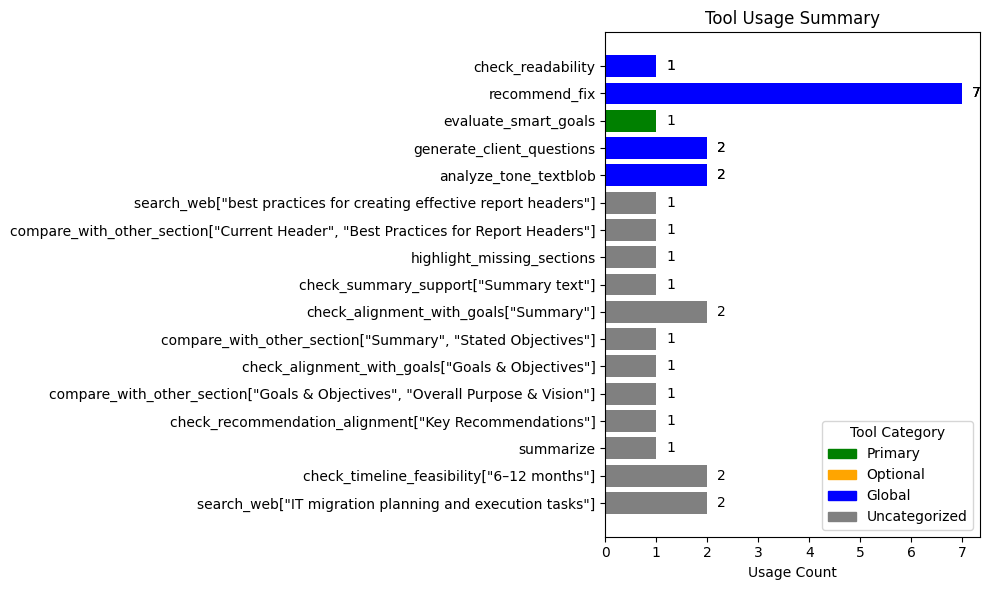

In [83]:
## Run ReAct on the full report of all sections
# Load report from file (txt, md)

# Boolean to control cell execution
execute_cell = True

if execute_cell:
    # Load report for review from file
    filepath = "../data/reports/sample_report.txt"
    raw_text = load_report_text_from_file(filepath)
    report_sections = split_report_into_sections(raw_text)

    # Initialize and run full report review
    react_agent = ReActConsultantAgent(section_name="Full Report", section_text="")
    react_agent = run_full_report_review(react_agent, report_sections)

    # Display summary
    print("\n🧾 Final Summary:\n")
    print(react_agent.memory["final_summary"])

    # Export
    await export_report_to_markdown_and_pdf(react_agent)
    print("✅ Report exported successfully.")

    # Tool usage summary
    print_tool_usage(react_agent)
    plot_tool_usage(react_agent.tool_usage)
else:
    print("Cell execution skipped.")
